# Artisign
### Penerjemah Bahasa Isyarat Indonesia (BISINDO)

Notebook ini bertujuan untuk membangun sistem penerjemah BISINDO, mencakup:
1.  Pengenalan isyarat abjad statis dari gambar/webcam.
2.  Pengenalan isyarat kata dinamis dari video/webcam (vokabular terbatas).
3.  Konversi teks ke representasi gambar isyarat (dasar).
4.  Penerapan Data Augmentation, Validasi Silang, dan eksplorasi model Transformer.

# Sel 2: Setup dan Import Library (Modifikasi)

In [1]:
!pip uninstall -y mediapipe numpy opencv-python tensorflow keras gradio flask tensorflowjs
!pip cache purge

!pip install numpy==1.26.4
!pip install mediapipe==0.10.9
!pip install opencv-python==4.9.0.80
!pip install tensorflow==2.17.0 keras==3.5.0
!pip install gradio flask
!pip install scikit-learn
!pip install tensorflowjs==4.20.0

import numpy as np
import mediapipe as mp
import cv2
import tensorflow as tf
import keras

print("NumPy:", np.__version__)
print("MediaPipe:", mp.__version__)
print("OpenCV:", cv2.__version__)
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)


import os
import json
import time
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import traceback

import subprocess
import shutil

from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, TimeDistributed, Input,
                                     GlobalAveragePooling2D, BatchNormalization, LayerNormalization, MultiHeadAttention,
                                     Embedding, Add, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

NumPy: 2.0.2
MediaPipe: 0.10.9
OpenCV: 4.11.0
TensorFlow: 2.18.0
Keras: 3.8.0


# Sel 4: Download dan Persiapkan Dataset

In [2]:
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive berhasil di-mount.")
except Exception as e:
    print(f"Error saat mount Google Drive: {e}")
    print("Pastikan Anda mengotorisasi akses ke Google Drive Anda.")

GDRIVE_BASE_PATH_DATASETS = '/content/drive/MyDrive/Artisign_Datasets/'
DATASET_IMAGE_PATH = os.path.join(GDRIVE_BASE_PATH_DATASETS, 'bisindo_image_dataset')
DATASET_VIDEO_PATH = os.path.join(GDRIVE_BASE_PATH_DATASETS, 'bisindo_video_dataset')

GDRIVE_BASE_PATH_OUTPUTS = '/content/drive/MyDrive/Artisign_Outputs/'
SAVE_PATH = os.path.join(GDRIVE_BASE_PATH_OUTPUTS, 'artisign_data_cv_drive_h5')
os.makedirs(SAVE_PATH, exist_ok=True)
print(f"Output akan disimpan di: {SAVE_PATH}")

if not os.path.exists(DATASET_IMAGE_PATH):
    print(f"PERINGATAN: Dataset gambar tidak ditemukan di path Google Drive: {DATASET_IMAGE_PATH}")
else:
    print(f"Dataset gambar ditemukan di: {DATASET_IMAGE_PATH}")

if not os.path.exists(DATASET_VIDEO_PATH):
    print(f"PERINGATAN: Dataset video tidak ditemukan di path Google Drive: {DATASET_VIDEO_PATH}")
else:
    print(f"Dataset video ditemukan di: {DATASET_VIDEO_PATH}")

IMAGE_TRAIN_PATH = os.path.join(DATASET_IMAGE_PATH, 'images', 'train')
VIDEO_RAW_PATH = os.path.join(DATASET_VIDEO_PATH, 'raw_video')

image_classes = []
if os.path.exists(IMAGE_TRAIN_PATH):
    image_classes = sorted([d for d in os.listdir(IMAGE_TRAIN_PATH) if os.path.isdir(os.path.join(IMAGE_TRAIN_PATH, d))])
image_classes_map = {cls: i for i, cls in enumerate(image_classes)}
print(f"Jumlah kelas dalam dataset gambar: {len(image_classes)}")

video_classes = []
if os.path.exists(VIDEO_RAW_PATH):
    video_classes = sorted([d for d in os.listdir(VIDEO_RAW_PATH) if os.path.isdir(os.path.join(VIDEO_RAW_PATH, d))])
video_classes_map = {cls: i for i, cls in enumerate(video_classes)}
print(f"Jumlah kelas dalam dataset video: {len(video_classes)}")

IMAGE_CLASS_MAPPING_FILE = os.path.join(SAVE_PATH, 'image_class_mapping.json')
VIDEO_CLASS_MAPPING_FILE = os.path.join(SAVE_PATH, 'video_class_mapping.json')

BEST_IMAGE_MODEL_FILE = os.path.join(SAVE_PATH, 'best_bisindo_image_model.h5')
BEST_LANDMARK_MODEL_FILE = os.path.join(SAVE_PATH, 'best_bisindo_landmark_model.h5')
BEST_VIDEO_LSTM_MODEL_FILE = os.path.join(SAVE_PATH, 'best_bisindo_video_lstm_model.h5')
BEST_VIDEO_TRANSFORMER_MODEL_FILE = os.path.join(SAVE_PATH, 'best_bisindo_video_transformer_model.h5')

IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_FRAMES_VIDEO = 30
MAX_SAMPLES_PER_IMAGE_CLASS = 500
MAX_VIDEOS_PER_CLASS = 50
NUM_LANDMARK_FEATURES = 21 * 3
N_FOLDS_CV = 5

Mounted at /content/drive
Google Drive berhasil di-mount.
Output akan disimpan di: /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5
Dataset gambar ditemukan di: /content/drive/MyDrive/Artisign_Datasets/bisindo_image_dataset
Dataset video ditemukan di: /content/drive/MyDrive/Artisign_Datasets/bisindo_video_dataset
Jumlah kelas dalam dataset gambar: 26
Jumlah kelas dalam dataset video: 40


# Sel 5: Preprocessing Data dan Ekstraksi Fitur

In [3]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def extract_hand_landmarks(image_bgr, hands_detector):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    results = hands_detector.process(image_rgb)
    processed_image_for_display = image_bgr.copy()
    landmarks_list = []

    if results.multi_hand_landmarks:
        for hand_idx, hand_landmarks_item in enumerate(results.multi_hand_landmarks):
            mp_drawing.draw_landmarks(
                processed_image_for_display,
                hand_landmarks_item,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )
            landmarks = []
            for landmark in hand_landmarks_item.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])

            if not landmarks_list:
                 landmarks_list.append(landmarks)
            break
    return landmarks_list, processed_image_for_display

def preprocess_image_dataset(dataset_base_path, target_size=(IMG_HEIGHT, IMG_WIDTH), max_samples=MAX_SAMPLES_PER_IMAGE_CLASS):
    X_landmarks_img_list = []
    X_images_cnn_list = []
    y_img_list = []

    if not os.path.exists(IMAGE_TRAIN_PATH):
        print(f"Path dataset gambar tidak ditemukan: {IMAGE_TRAIN_PATH}")
        return np.array(X_images_cnn_list), np.array(X_landmarks_img_list), np.array(y_img_list), []

    local_image_classes = sorted([d for d in os.listdir(IMAGE_TRAIN_PATH) if os.path.isdir(os.path.join(IMAGE_TRAIN_PATH, d))])
    if not local_image_classes:
        print(f"Tidak ada kelas ditemukan di {IMAGE_TRAIN_PATH}")
        return np.array(X_images_cnn_list), np.array(X_landmarks_img_list), np.array(y_img_list), []

    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        for class_idx, class_name in enumerate(tqdm(local_image_classes, desc="Processing Image Dataset")):
            class_path = os.path.join(IMAGE_TRAIN_PATH, class_name)
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if len(image_files) > max_samples:
                image_files = np.random.choice(image_files, max_samples, replace=False).tolist()

            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                image = cv2.imread(img_path)
                if image is None: continue

                resized_image_for_landmark = cv2.resize(image, target_size)
                landmarks_list, _ = extract_hand_landmarks(resized_image_for_landmark, hands)

                if landmarks_list:
                    X_landmarks_img_list.append(landmarks_list[0])
                    X_images_cnn_list.append(img_path)
                    y_img_list.append(class_idx)

    print(f"Dataset gambar (abjad) setelah preprocessing: {len(X_landmarks_img_list)} sampel landmark, {len(X_images_cnn_list)} path gambar.")
    return X_images_cnn_list, np.array(X_landmarks_img_list), np.array(y_img_list), local_image_classes


def preprocess_video_dataset(dataset_base_path, num_target_frames=NUM_FRAMES_VIDEO, target_size=(IMG_HEIGHT, IMG_WIDTH), max_videos=MAX_VIDEOS_PER_CLASS):
    X_video_sequences_list = []
    y_video_list = []

    if not os.path.exists(VIDEO_RAW_PATH):
        print(f"Path dataset video tidak ditemukan: {VIDEO_RAW_PATH}")
        return np.array(X_video_sequences_list), np.array(y_video_list), []

    local_video_classes = sorted([d for d in os.listdir(VIDEO_RAW_PATH) if os.path.isdir(os.path.join(VIDEO_RAW_PATH, d))])
    if not local_video_classes:
        print(f"Tidak ada kelas ditemukan di {VIDEO_RAW_PATH}")
        return np.array(X_video_sequences_list), np.array(y_video_list), []

    with mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5) as hands:
        for class_idx, class_name in enumerate(tqdm(local_video_classes, desc="Processing Video Dataset")):
            class_path = os.path.join(VIDEO_RAW_PATH, class_name)
            video_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]

            if len(video_files) > max_videos:
                video_files = np.random.choice(video_files, max_videos, replace=False).tolist()

            for video_file in video_files:
                video_path = os.path.join(class_path, video_file)
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened(): continue

                total_frames_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                frame_indices = np.linspace(0, total_frames_video - 1, num_target_frames, dtype=int) if total_frames_video > num_target_frames else range(total_frames_video)

                video_landmarks_sequence = []
                for i in range(total_frames_video):
                    ret, frame = cap.read()
                    if not ret: break
                    if i in frame_indices:
                        resized_frame = cv2.resize(frame, target_size)
                        landmarks_list, _ = extract_hand_landmarks(resized_frame, hands)
                        video_landmarks_sequence.append(landmarks_list[0] if landmarks_list else np.zeros(NUM_LANDMARK_FEATURES))
                cap.release()

                while len(video_landmarks_sequence) < num_target_frames:
                    video_landmarks_sequence.append(np.zeros(NUM_LANDMARK_FEATURES))
                video_landmarks_sequence = video_landmarks_sequence[:num_target_frames]

                if len(video_landmarks_sequence) == num_target_frames:
                    X_video_sequences_list.append(video_landmarks_sequence)
                    y_video_list.append(class_idx)

    print(f"Dataset video (kata) setelah preprocessing: {len(X_video_sequences_list)} sampel.")
    return np.array(X_video_sequences_list), np.array(y_video_list), local_video_classes

print("Memulai preprocessing dataset gambar (abjad)...")
X_image_paths_cnn, X_landmarks_img_all, y_img_all, current_image_classes = preprocess_image_dataset(DATASET_IMAGE_PATH)

print("\nMemulai preprocessing dataset video (kata)...")
X_video_sequences_all, y_video_all, current_video_classes = preprocess_video_dataset(DATASET_VIDEO_PATH)

image_classes = current_image_classes
video_classes = current_video_classes

df_images = pd.DataFrame({'filepath': X_image_paths_cnn, 'label_str': [image_classes[i] for i in y_img_all], 'label_int': y_img_all})


if len(y_img_all) > 0:
    y_img_onehot_all = to_categorical(y_img_all, num_classes=len(image_classes))
else:
    y_img_onehot_all = np.array([])

if len(y_video_all) > 0:
    y_video_onehot_all = to_categorical(y_video_all, num_classes=len(video_classes))
else:
    y_video_onehot_all = np.array([])

image_class_mapping_save = {i: name for i, name in enumerate(image_classes)}
with open(IMAGE_CLASS_MAPPING_FILE, 'w') as f: json.dump(image_class_mapping_save, f)

video_class_mapping_save = {i: name for i, name in enumerate(video_classes)}
with open(VIDEO_CLASS_MAPPING_FILE, 'w') as f: json.dump(video_class_mapping_save, f)


X_lm_img_train_val, X_lm_img_test, y_img_train_val_onehot, y_img_test_onehot, df_images_train_val, df_images_test = [np.array([])]*6

if X_landmarks_img_all.shape[0] > 0:
    indices_img = np.arange(X_landmarks_img_all.shape[0])

    X_lm_img_train_val_indices, X_lm_img_test_indices, \
    y_img_train_val_labels, _ = train_test_split(indices_img, y_img_all, test_size=0.2, random_state=42, stratify=y_img_all)

    X_lm_img_train_val = X_landmarks_img_all[X_lm_img_train_val_indices]
    X_lm_img_test = X_landmarks_img_all[X_lm_img_test_indices]
    y_img_train_val_onehot = y_img_onehot_all[X_lm_img_train_val_indices]
    y_img_test_onehot = y_img_onehot_all[X_lm_img_test_indices]

    df_images_train_val, df_images_test = train_test_split(df_images, test_size=0.2, random_state=42, stratify=df_images['label_int'])


X_vid_seq_train_val, X_vid_seq_test, y_vid_train_val_onehot, y_vid_test_onehot = [np.array([])]*4
if X_video_sequences_all.shape[0] > 0:
    X_vid_seq_train_val, X_vid_seq_test, \
    y_vid_train_val_onehot, y_vid_test_onehot = train_test_split(X_video_sequences_all, y_video_onehot_all,
                                                                 test_size=0.2, random_state=42, stratify=y_video_onehot_all)

print(f"Data Latih/Validasi CNN (paths): {len(df_images_train_val)}")
print(f"Data Tes CNN (paths): {len(df_images_test)}")
print(f"Data Latih/Validasi Landmark: {X_lm_img_train_val.shape[0]}")
print(f"Data Tes Landmark: {X_lm_img_test.shape[0]}")
print(f"Data Latih/Validasi Video: {X_vid_seq_train_val.shape[0]}")
print(f"Data Tes Video: {X_vid_seq_test.shape[0]}")

Memulai preprocessing dataset gambar (abjad)...


Processing Image Dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Dataset gambar (abjad) setelah preprocessing: 7943 sampel landmark, 7943 path gambar.

Memulai preprocessing dataset video (kata)...


Processing Video Dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Dataset video (kata) setelah preprocessing: 2000 sampel.
Data Latih/Validasi CNN (paths): 6354
Data Tes CNN (paths): 1589
Data Latih/Validasi Landmark: 6354
Data Tes Landmark: 1589
Data Latih/Validasi Video: 1600
Data Tes Video: 400


# Sel 6: Pembuatan Model

In [4]:
def create_image_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes_img=len(image_classes)):
    if num_classes_img == 0:
        print("Jumlah kelas gambar adalah 0, tidak dapat membuat model CNN.")
        return None
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
         layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes_img, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_landmark_model(input_shape_lm=(NUM_LANDMARK_FEATURES,), num_classes_img=len(image_classes)):
    if num_classes_img == 0: return None
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape_lm),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes_img, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_video_lstm_model(input_shape_vid=(NUM_FRAMES_VIDEO, NUM_LANDMARK_FEATURES), num_classes_vid=len(video_classes)):
    if num_classes_vid == 0: return None
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape_vid),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=False),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes_vid, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(self.position, self.d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]

def create_video_transformer_model(input_shape_vid=(NUM_FRAMES_VIDEO, NUM_LANDMARK_FEATURES), num_classes_vid=len(video_classes), d_model=128, num_heads=8, ff_dim=128, num_transformer_blocks=2):
    if num_classes_vid == 0: return None

    inputs = Input(shape=input_shape_vid, dtype=tf.float32)
    x = layers.Dense(d_model, activation="relu")(inputs)
    x = PositionalEncoding(position=input_shape_vid[0], d_model=d_model)(x)

    for _ in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        ffn_output = layers.Dense(ff_dim, activation="relu")(x)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(d_model, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes_vid, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("Definisi model (dengan perbaikan PositionalEncoding) selesai.")

Definisi model (dengan perbaikan PositionalEncoding) selesai.


# Sel 7: Training Model (Modifikasi Besar untuk K-Fold dan Augmentasi)

In [7]:
train_image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=False,
    fill_mode='nearest'
)
val_image_datagen = ImageDataGenerator(rescale=1./255)

kf = StratifiedKFold(n_splits=N_FOLDS_CV, shuffle=True, random_state=42)
transformer_custom_objects_for_training = {'PositionalEncoding': PositionalEncoding}

all_cnn_histories = []
all_cnn_test_accuracies = []
all_lm_histories = []
all_lm_test_accuracies = []
all_lstm_histories = []
all_lstm_test_accuracies = []
all_transformer_histories = []
all_transformer_test_accuracies = []


def train_evaluate_image_cnn_fold(df_train_fold, df_val_fold, df_test_global,
                                   class_names_list, fold_no, model_save_path_base,
                                   epochs=50, batch_size=32):
    model_checkpoint_path = f"{model_save_path_base}_fold{fold_no}.h5"
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-7, verbose=1)
    model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)
    callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

    print(f"\n--- Fold {fold_no} untuk Image CNN ---")
    model = create_image_cnn_model(num_classes_img=len(class_names_list))
    if model is None or df_train_fold.empty or df_val_fold.empty:
        print(f"Skipping Image CNN for fold {fold_no} due to missing model or empty dataframes.")
        return None, 0.0

    train_generator = train_image_datagen.flow_from_dataframe(
        df_train_fold, x_col='filepath', y_col='label_str', target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size, class_mode='categorical', classes=class_names_list, shuffle=True)
    val_generator = val_image_datagen.flow_from_dataframe(
        df_val_fold, x_col='filepath', y_col='label_str', target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size, class_mode='categorical', classes=class_names_list, shuffle=False)

    history = model.fit(
        train_generator, epochs=epochs, validation_data=val_generator,
        callbacks=callbacks_list, verbose=1)

    test_accuracy_on_global_test = 0.0
    if os.path.exists(model_checkpoint_path) and (df_test_global is not None and not df_test_global.empty):
        print(f"Loading best model from fold {fold_no} ({model_checkpoint_path}) for global test evaluation...")
        try:
            loaded_model_fold = keras.models.load_model(model_checkpoint_path)
            test_generator_global = val_image_datagen.flow_from_dataframe(
                df_test_global, x_col='filepath', y_col='label_str', target_size=(IMG_HEIGHT, IMG_WIDTH),
                batch_size=batch_size, class_mode='categorical', classes=class_names_list, shuffle=False)
            _, test_accuracy_on_global_test = loaded_model_fold.evaluate(test_generator_global, verbose=0)
            print(f"Fold {fold_no} Test Accuracy (on global test set): {test_accuracy_on_global_test:.4f}")
        except Exception as e:
            print(f"Error loading or evaluating CNN model from fold {fold_no} on global test set: {e}")
    return history, test_accuracy_on_global_test


def train_evaluate_fold(model_type, X_train_data, y_train_data, X_val_data, y_val_data,
                        X_test_global, y_test_global_onehot,
                        class_names_list, fold_no, model_save_path_base, epochs=50, batch_size=32,
                        custom_objects_for_load=None):
    model_checkpoint_path = f"{model_save_path_base}_fold{fold_no}.h5"

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-7, verbose=1)
    model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)
    callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

    print(f"\n--- Fold {fold_no} untuk {model_type} ---")
    model = None
    history = None
    num_classes = len(class_names_list)

    if num_classes == 0:
        print(f"Skipping {model_type} for fold {fold_no} due to zero classes.")
        return None, 0.0
    if X_train_data is None or X_train_data.shape[0] == 0 or X_val_data is None or X_val_data.shape[0] == 0 :
        print(f"Skipping {model_type} for fold {fold_no} due to empty train/val data.")
        return None, 0.0

    if model_type == "landmark_mlp":
        model = create_landmark_model(num_classes_img=num_classes)
    elif model_type == "video_lstm":
        model = create_video_lstm_model(num_classes_vid=num_classes)
    elif model_type == "video_transformer":
        model = create_video_transformer_model(num_classes_vid=num_classes)

    if model is None:
        print(f"Failed to create {model_type} model for fold {fold_no}.")
        return None, 0.0

    current_batch_size = batch_size
    if model_type in ["video_lstm", "video_transformer"]:
        current_batch_size = batch_size // 2 if batch_size // 2 > 0 else 1

    history = model.fit(X_train_data, y_train_data, batch_size=current_batch_size, epochs=epochs,
                        validation_data=(X_val_data, y_val_data), callbacks=callbacks_list, verbose=1)

    test_accuracy_on_global_test = 0.0
    if os.path.exists(model_checkpoint_path) and \
       (X_test_global is not None and X_test_global.shape[0] > 0) and \
       (y_test_global_onehot is not None and y_test_global_onehot.shape[0] > 0):
        print(f"Loading best model from fold {fold_no} ({model_checkpoint_path}) for global test evaluation...")
        try:
            loaded_model_fold = keras.models.load_model(model_checkpoint_path, custom_objects=custom_objects_for_load)
            if loaded_model_fold:
                 _, test_accuracy_on_global_test = loaded_model_fold.evaluate(X_test_global, y_test_global_onehot, verbose=0)
                 print(f"Fold {fold_no} Test Accuracy (on global test set): {test_accuracy_on_global_test:.4f}")
            else:
                print(f"Model from fold {fold_no} is None after loading attempt.")
        except Exception as e:
            print(f"Error loading or evaluating {model_type} model from fold {fold_no} on global test set: {e}")
    else:
        print(f"Skipping global test evaluation for {model_type} fold {fold_no} due to missing model file or empty global test data.")

    return history, test_accuracy_on_global_test

if 'df_images_train_val' in globals() and not df_images_train_val.empty and len(image_classes) > 0:
    print("\nMemulai K-Fold Training untuk Image CNN Model (Abjad)...")
    y_img_train_val_labels_cnn = df_images_train_val['label_int'].values

    fold_counter_cnn = 1
    for train_indices, val_indices in kf.split(df_images_train_val, y_img_train_val_labels_cnn):
        df_train_fold, df_val_fold = df_images_train_val.iloc[train_indices], df_images_train_val.iloc[val_indices]
        hist_cnn, acc_cnn = train_evaluate_image_cnn_fold(
            df_train_fold, df_val_fold, df_images_test, image_classes, fold_counter_cnn,
            os.path.join(SAVE_PATH, "image_cnn_model"), epochs=5, batch_size=32)
        if hist_cnn: all_cnn_histories.append(hist_cnn)
        all_cnn_test_accuracies.append(acc_cnn)
        fold_counter_cnn += 1

    if all_cnn_test_accuracies and any(acc > 0 for acc in all_cnn_test_accuracies):
        print(f"\nRata-rata Test Accuracy Image CNN (on global test set) setelah {N_FOLDS_CV}-Fold CV: {np.mean(all_cnn_test_accuracies):.4f} (+/- {np.std(all_cnn_test_accuracies):.4f})")
        best_fold_idx_cnn = np.argmax(all_cnn_test_accuracies)
        best_model_path_cnn_fold = os.path.join(SAVE_PATH, f"image_cnn_model_fold{best_fold_idx_cnn+1}.h5")
        if os.path.exists(best_model_path_cnn_fold):
            print(f"Menyimpan model Image CNN terbaik dari fold {best_fold_idx_cnn+1} sebagai {BEST_IMAGE_MODEL_FILE}")
            shutil.copy(best_model_path_cnn_fold, BEST_IMAGE_MODEL_FILE)
        else:
            print(f"File model CNN terbaik untuk fold {best_fold_idx_cnn+1} tidak ditemukan.")
    else:
        print("Tidak ada akurasi valid untuk Image CNN, model terbaik tidak disimpan.")
else:
    print("Skipping K-Fold Training untuk Image CNN Model (Abjad) karena data tidak siap.")

if 'X_lm_img_train_val' in globals() and X_lm_img_train_val.shape[0] > 0 and len(image_classes) > 0:
    print("\nMemulai K-Fold Training untuk Landmark MLP Model (Abjad)...")
    y_lm_img_train_val_labels = np.argmax(y_img_train_val_onehot, axis=1)

    fold_counter_lm = 1
    for train_indices, val_indices in kf.split(X_lm_img_train_val, y_lm_img_train_val_labels):
        X_train_fold, X_val_fold = X_lm_img_train_val[train_indices], X_lm_img_train_val[val_indices]
        y_train_fold, y_val_fold = y_img_train_val_onehot[train_indices], y_img_train_val_onehot[val_indices]
        hist_lm, acc_lm = train_evaluate_fold(
            "landmark_mlp", X_train_fold, y_train_fold, X_val_fold, y_val_fold,
            X_lm_img_test, y_img_test_onehot, image_classes, fold_counter_lm,
            os.path.join(SAVE_PATH, "landmark_mlp_model"), epochs=75, batch_size=32)
        if hist_lm: all_lm_histories.append(hist_lm)
        all_lm_test_accuracies.append(acc_lm)
        fold_counter_lm += 1

    if all_lm_test_accuracies and any(acc > 0 for acc in all_lm_test_accuracies):
        print(f"\nRata-rata Test Accuracy Landmark MLP (on global test set) setelah {N_FOLDS_CV}-Fold CV: {np.mean(all_lm_test_accuracies):.4f} (+/- {np.std(all_lm_test_accuracies):.4f})")
        best_fold_idx_lm = np.argmax(all_lm_test_accuracies)
        best_model_path_lm_fold = os.path.join(SAVE_PATH, f"landmark_mlp_model_fold{best_fold_idx_lm+1}.h5")
        if os.path.exists(best_model_path_lm_fold):
            print(f"Menyimpan model Landmark MLP terbaik dari fold {best_fold_idx_lm+1} sebagai {BEST_LANDMARK_MODEL_FILE}")
            shutil.copy(best_model_path_lm_fold, BEST_LANDMARK_MODEL_FILE)
        else:
            print(f"File model Landmark MLP terbaik untuk fold {best_fold_idx_lm+1} tidak ditemukan.")
    else:
        print("Tidak ada akurasi valid untuk Landmark MLP, model terbaik tidak disimpan.")
else:
    print("Skipping K-Fold Training untuk Landmark MLP Model (Abjad) karena data tidak siap.")

if 'X_vid_seq_train_val' in globals() and X_vid_seq_train_val.shape[0] > 0 and len(video_classes) > 0:
    print("\nMemulai K-Fold Training untuk Video LSTM Model (Kata)...")
    y_vid_train_val_labels_lstm = np.argmax(y_vid_train_val_onehot, axis=1)

    fold_counter_lstm = 1
    for train_indices, val_indices in kf.split(X_vid_seq_train_val, y_vid_train_val_labels_lstm):
        X_train_fold, X_val_fold = X_vid_seq_train_val[train_indices], X_vid_seq_train_val[val_indices]
        y_train_fold, y_val_fold = y_vid_train_val_onehot[train_indices], y_vid_train_val_onehot[val_indices]
        hist_lstm, acc_lstm = train_evaluate_fold(
            "video_lstm", X_train_fold, y_train_fold, X_val_fold, y_val_fold,
            X_vid_seq_test, y_vid_test_onehot, video_classes, fold_counter_lstm,
            os.path.join(SAVE_PATH, "video_lstm_model"), epochs=150, batch_size=16)
        if hist_lstm: all_lstm_histories.append(hist_lstm)
        all_lstm_test_accuracies.append(acc_lstm)
        fold_counter_lstm += 1

    if all_lstm_test_accuracies and any(acc > 0 for acc in all_lstm_test_accuracies):
        print(f"\nRata-rata Test Accuracy Video LSTM (on global test set) setelah {N_FOLDS_CV}-Fold CV: {np.mean(all_lstm_test_accuracies):.4f} (+/- {np.std(all_lstm_test_accuracies):.4f})")
        best_fold_idx_lstm = np.argmax(all_lstm_test_accuracies)
        best_model_path_lstm_fold = os.path.join(SAVE_PATH, f"video_lstm_model_fold{best_fold_idx_lstm+1}.h5")
        if os.path.exists(best_model_path_lstm_fold):
            print(f"Menyimpan model Video LSTM terbaik dari fold {best_fold_idx_lstm+1} sebagai {BEST_VIDEO_LSTM_MODEL_FILE}")
            shutil.copy(best_model_path_lstm_fold, BEST_VIDEO_LSTM_MODEL_FILE)
        else:
            print(f"File model Video LSTM terbaik untuk fold {best_fold_idx_lstm+1} tidak ditemukan.")
    else:
        print("Tidak ada akurasi valid untuk Video LSTM, model terbaik tidak disimpan.")
else:
    print("Skipping K-Fold Training untuk Video LSTM Model (Kata) karena data tidak siap.")

if 'X_vid_seq_train_val' in globals() and X_vid_seq_train_val.shape[0] > 0 and len(video_classes) > 0:
    print("\nMemulai K-Fold Training untuk Video Transformer Model (Kata)...")
    y_vid_train_val_labels_tf = np.argmax(y_vid_train_val_onehot, axis=1)

    fold_counter_tf = 1
    for train_indices, val_indices in kf.split(X_vid_seq_train_val, y_vid_train_val_labels_tf):
        X_train_fold, X_val_fold = X_vid_seq_train_val[train_indices], X_vid_seq_train_val[val_indices]
        y_train_fold, y_val_fold = y_vid_train_val_onehot[train_indices], y_vid_train_val_onehot[val_indices]
        hist_tf, acc_tf = train_evaluate_fold(
            "video_transformer", X_train_fold, y_train_fold, X_val_fold, y_val_fold,
            X_vid_seq_test, y_vid_test_onehot, video_classes, fold_counter_tf,
            os.path.join(SAVE_PATH, "video_transformer_model"),
            epochs=150, batch_size=16,
            custom_objects_for_load=transformer_custom_objects_for_training)
        if hist_tf: all_transformer_histories.append(hist_tf)
        all_transformer_test_accuracies.append(acc_tf)
        fold_counter_tf += 1

    if all_transformer_test_accuracies and any(acc > 0 for acc in all_transformer_test_accuracies):
        print(f"\nRata-rata Test Accuracy Video Transformer (on global test set) setelah {N_FOLDS_CV}-Fold CV: {np.mean(all_transformer_test_accuracies):.4f} (+/- {np.std(all_transformer_test_accuracies):.4f})")
        best_fold_idx_tf = np.argmax(all_transformer_test_accuracies)
        best_model_path_tf_fold = os.path.join(SAVE_PATH, f"video_transformer_model_fold{best_fold_idx_tf+1}.h5")
        if os.path.exists(best_model_path_tf_fold):
            print(f"Menyimpan model Video Transformer terbaik dari fold {best_fold_idx_tf+1} sebagai {BEST_VIDEO_TRANSFORMER_MODEL_FILE}")
            shutil.copy(best_model_path_tf_fold, BEST_VIDEO_TRANSFORMER_MODEL_FILE)
        else:
            print(f"File model Video Transformer terbaik untuk fold {best_fold_idx_tf+1} tidak ditemukan.")
    else:
        print("Tidak ada akurasi valid untuk Video Transformer, model terbaik tidak disimpan.")
else:
    print("Skipping K-Fold Training untuk Video Transformer Model (Kata) karena data tidak siap.")


Memulai K-Fold Training untuk Image CNN Model (Abjad)...

--- Fold 1 untuk Image CNN ---
Found 5083 validated image filenames belonging to 26 classes.
Found 1271 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.2419 - loss: 2.7970
Epoch 1: val_accuracy improved from -inf to 0.71125, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 122s 599ms/step - accuracy: 0.2432 - loss: 2.7926 - val_accuracy: 0.7113 - val_loss: 0.9895 - learning_rate: 1.0000e-04
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7692 - loss: 0.8520
Epoch 2: val_accuracy improved from 0.71125 to 0.85287, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 84s 528ms/step - accuracy: 0.7693 - loss: 0.8512 - val_accuracy: 0.8529 - val_loss: 0.4782 - learning_rate: 1.0000e-04
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8820 - loss: 0.4095
Epoch 3: val_accuracy improved from 0.85287 to 0.90559, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 84s 528ms/step - accuracy: 0.8821 - loss: 0.4092 - val_accuracy: 0.9056 - val_loss: 0.2904 - learning_rate: 1.0000e-04
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9287 - loss: 0.2346
Epoch 4: val_accuracy improved from 0.90559 to 0.94965, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 89s 562ms/step - accuracy: 0.9287 - loss: 0.2346 - val_accuracy: 0.9496 - val_loss: 0.1615 - learning_rate: 1.0000e-04
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.9536 - loss: 0.1536
Epoch 5: val_accuracy improved from 0.94965 to 0.95830, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 85s 534ms/step - accuracy: 0.9536 - loss: 0.1535 - val_accuracy: 0.9583 - val_loss: 0.1438 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.
Loading best model from fold 1 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold1.h5) for global test evaluation...


Found 1589 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 Test Accuracy (on global test set): 0.9585

--- Fold 2 untuk Image CNN ---
Found 5083 validated image filenames belonging to 26 classes.
Found 1271 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.2546 - loss: 2.7439
Epoch 1: val_accuracy improved from -inf to 0.66404, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 121s 590ms/step - accuracy: 0.2558 - loss: 2.7394 - val_accuracy: 0.6640 - val_loss: 1.1400 - learning_rate: 1.0000e-04
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7746 - loss: 0.8271
Epoch 2: val_accuracy improved from 0.66404 to 0.83950, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 88s 551ms/step - accuracy: 0.7748 - loss: 0.8263 - val_accuracy: 0.8395 - val_loss: 0.5102 - learning_rate: 1.0000e-04
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8724 - loss: 0.4302
Epoch 3: val_accuracy improved from 0.83950 to 0.89064, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 89s 558ms/step - accuracy: 0.8725 - loss: 0.4299 - val_accuracy: 0.8906 - val_loss: 0.3439 - learning_rate: 1.0000e-04
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9335 - loss: 0.2323
Epoch 4: val_accuracy improved from 0.89064 to 0.91424, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 88s 554ms/step - accuracy: 0.9335 - loss: 0.2322 - val_accuracy: 0.9142 - val_loss: 0.2764 - learning_rate: 1.0000e-04
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9588 - loss: 0.1395
Epoch 5: val_accuracy improved from 0.91424 to 0.94965, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 89s 559ms/step - accuracy: 0.9588 - loss: 0.1396 - val_accuracy: 0.9496 - val_loss: 0.1509 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.
Loading best model from fold 2 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold2.h5) for global test evaluation...


Found 1589 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 2 Test Accuracy (on global test set): 0.9478

--- Fold 3 untuk Image CNN ---
Found 5083 validated image filenames belonging to 26 classes.
Found 1271 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.2458 - loss: 2.7698
Epoch 1: val_accuracy improved from -inf to 0.61133, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 124s 605ms/step - accuracy: 0.2470 - loss: 2.7655 - val_accuracy: 0.6113 - val_loss: 1.2934 - learning_rate: 1.0000e-04
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.7609 - loss: 0.8576
Epoch 2: val_accuracy improved from 0.61133 to 0.78363, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 89s 559ms/step - accuracy: 0.7611 - loss: 0.8569 - val_accuracy: 0.7836 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8765 - loss: 0.4339
Epoch 3: val_accuracy improved from 0.78363 to 0.86861, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 89s 558ms/step - accuracy: 0.8766 - loss: 0.4336 - val_accuracy: 0.8686 - val_loss: 0.3967 - learning_rate: 1.0000e-04
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9272 - loss: 0.2377
Epoch 4: val_accuracy improved from 0.86861 to 0.91424, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 88s 555ms/step - accuracy: 0.9272 - loss: 0.2375 - val_accuracy: 0.9142 - val_loss: 0.2624 - learning_rate: 1.0000e-04
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9565 - loss: 0.1413
Epoch 5: val_accuracy improved from 0.91424 to 0.94650, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 84s 528ms/step - accuracy: 0.9565 - loss: 0.1413 - val_accuracy: 0.9465 - val_loss: 0.1626 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.
Loading best model from fold 3 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold3.h5) for global test evaluation...


Found 1589 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 3 Test Accuracy (on global test set): 0.9396

--- Fold 4 untuk Image CNN ---
Found 5083 validated image filenames belonging to 26 classes.
Found 1271 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.2499 - loss: 2.7505
Epoch 1: val_accuracy improved from -inf to 0.70732, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 120s 595ms/step - accuracy: 0.2511 - loss: 2.7461 - val_accuracy: 0.7073 - val_loss: 1.0521 - learning_rate: 1.0000e-04
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7698 - loss: 0.8439
Epoch 2: val_accuracy improved from 0.70732 to 0.86546, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 518ms/step - accuracy: 0.7700 - loss: 0.8433 - val_accuracy: 0.8655 - val_loss: 0.4487 - learning_rate: 1.0000e-04
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8716 - loss: 0.4281
Epoch 3: val_accuracy improved from 0.86546 to 0.91739, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 88s 551ms/step - accuracy: 0.8717 - loss: 0.4278 - val_accuracy: 0.9174 - val_loss: 0.2794 - learning_rate: 1.0000e-04
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9300 - loss: 0.2339
Epoch 4: val_accuracy improved from 0.91739 to 0.94650, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 84s 527ms/step - accuracy: 0.9300 - loss: 0.2339 - val_accuracy: 0.9465 - val_loss: 0.1840 - learning_rate: 1.0000e-04
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9538 - loss: 0.1609
Epoch 5: val_accuracy improved from 0.94650 to 0.94886, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 88s 556ms/step - accuracy: 0.9538 - loss: 0.1608 - val_accuracy: 0.9489 - val_loss: 0.1622 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.
Loading best model from fold 4 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold4.h5) for global test evaluation...


Found 1589 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 4 Test Accuracy (on global test set): 0.9553

--- Fold 5 untuk Image CNN ---
Found 5084 validated image filenames belonging to 26 classes.
Found 1270 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.2583 - loss: 2.7647
Epoch 1: val_accuracy improved from -inf to 0.64724, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 126s 628ms/step - accuracy: 0.2595 - loss: 2.7602 - val_accuracy: 0.6472 - val_loss: 1.2318 - learning_rate: 1.0000e-04
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.7654 - loss: 0.8775
Epoch 2: val_accuracy improved from 0.64724 to 0.82756, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 85s 537ms/step - accuracy: 0.7656 - loss: 0.8766 - val_accuracy: 0.8276 - val_loss: 0.5618 - learning_rate: 1.0000e-04
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8699 - loss: 0.4212
Epoch 3: val_accuracy improved from 0.82756 to 0.91417, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 89s 560ms/step - accuracy: 0.8700 - loss: 0.4209 - val_accuracy: 0.9142 - val_loss: 0.2626 - learning_rate: 1.0000e-04
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9318 - loss: 0.2463
Epoch 4: val_accuracy improved from 0.91417 to 0.94961, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 86s 543ms/step - accuracy: 0.9318 - loss: 0.2462 - val_accuracy: 0.9496 - val_loss: 0.1870 - learning_rate: 1.0000e-04
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9596 - loss: 0.1398
Epoch 5: val_accuracy improved from 0.94961 to 0.97638, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 87s 549ms/step - accuracy: 0.9597 - loss: 0.1398 - val_accuracy: 0.9764 - val_loss: 0.0774 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.
Loading best model from fold 5 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/image_cnn_model_fold5.h5) for global test evaluation...


Found 1589 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 5 Test Accuracy (on global test set): 0.9679

Rata-rata Test Accuracy Image CNN (on global test set) setelah 5-Fold CV: 0.9538 (+/- 0.0096)
Menyimpan model Image CNN terbaik dari fold 5 sebagai /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/best_bisindo_image_model.h5

Memulai K-Fold Training untuk Landmark MLP Model (Abjad)...

--- Fold 1 untuk landmark_mlp ---
Epoch 1/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0749 - loss: 3.1941
Epoch 1: val_accuracy improved from -inf to 0.26987, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.0753 - loss: 3.1931 - val_accuracy: 0.2699 - val_loss: 2.4464 - learning_rate: 0.0010
Epoch 2/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2870 - loss: 2.4099
Epoch 2: val_accuracy improved from 0.26987 to 0.47915, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2903 - loss: 2.3957 - val_accuracy: 0.4792 - val_loss: 1.7840 - learning_rate: 0.0010
Epoch 3/75
147/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4292 - loss: 1.8428
Epoch 3: val_accuracy improved from 0.47915 to 0.52557, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4301 - loss: 1.8367 - val_accuracy: 0.5256 - val_loss: 1.4704 - learning_rate: 0.0010
Epoch 4/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4899 - loss: 1.5981
Epoch 4: val_accuracy improved from 0.52557 to 0.65854, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4914 - loss: 1.5931 - val_accuracy: 0.6585 - val_loss: 1.1897 - learning_rate: 0.0010
Epoch 5/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5500 - loss: 1.4078
Epoch 5: val_accuracy improved from 0.65854 to 0.68686, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5509 - loss: 1.4056 - val_accuracy: 0.6869 - val_loss: 1.0667 - learning_rate: 0.0010
Epoch 6/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6052 - loss: 1.2611
Epoch 6: val_accuracy improved from 0.68686 to 0.73958, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6042 - loss: 1.2613 - val_accuracy: 0.7396 - val_loss: 0.9662 - learning_rate: 0.0010
Epoch 7/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6125 - loss: 1.2317
Epoch 7: val_accuracy improved from 0.73958 to 0.74194, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6127 - loss: 1.2273 - val_accuracy: 0.7419 - val_loss: 0.9237 - learning_rate: 0.0010
Epoch 8/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6380 - loss: 1.1368
Epoch 8: val_accuracy improved from 0.74194 to 0.76003, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6389 - loss: 1.1317 - val_accuracy: 0.7600 - val_loss: 0.8289 - learning_rate: 0.0010
Epoch 9/75
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6570 - loss: 1.0960
Epoch 9: val_accuracy improved from 0.76003 to 0.77498, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6571 - loss: 1.0956 - val_accuracy: 0.7750 - val_loss: 0.8184 - learning_rate: 0.0010
Epoch 10/75
155/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6715 - loss: 1.0148
Epoch 10: val_accuracy improved from 0.77498 to 0.80016, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6716 - loss: 1.0145 - val_accuracy: 0.8002 - val_loss: 0.7706 - learning_rate: 0.0010
Epoch 11/75
152/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6883 - loss: 0.9756
Epoch 11: val_accuracy improved from 0.80016 to 0.80803, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6884 - loss: 0.9753 - val_accuracy: 0.8080 - val_loss: 0.7307 - learning_rate: 0.0010
Epoch 12/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7139 - loss: 0.9190
Epoch 12: val_accuracy improved from 0.80803 to 0.82769, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7131 - loss: 0.9180 - val_accuracy: 0.8277 - val_loss: 0.6909 - learning_rate: 0.0010
Epoch 13/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.9011
Epoch 13: val_accuracy did not improve from 0.82769
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7196 - loss: 0.8989 - val_accuracy: 0.8190 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 14/75
136/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7117 - loss: 0.8576
Epoch 14: val_accuracy did not improve from 0.82769
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7131 - loss: 0.8572 - val_accuracy: 0.8269 - val_loss: 0.6492 - learning_rate: 0.0010
Epoch 15/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7429 - loss: 0.8163
Epoch 15: val_accuracy improved from 0.82769 to 0.82848, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7423 - loss: 0.8183 - val_accuracy: 0.8285 - val_loss: 0.6321 - learning_rate: 0.0010
Epoch 16/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7371 - loss: 0.8314
Epoch 16: val_accuracy improved from 0.82848 to 0.84815, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7380 - loss: 0.8295 - val_accuracy: 0.8482 - val_loss: 0.5877 - learning_rate: 0.0010
Epoch 17/75
156/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7417 - loss: 0.8055
Epoch 17: val_accuracy did not improve from 0.84815
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7418 - loss: 0.8050 - val_accuracy: 0.8371 - val_loss: 0.5893 - learning_rate: 0.0010
Epoch 18/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7590 - loss: 0.7556
Epoch 18: val_accuracy did not improve from 0.84815
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7590 - loss: 0.7556 - val_accuracy: 0.8316 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 19/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7674 - loss: 0.7574
Epoch 19: val_accuracy improved from 0.84815 to 0.85759, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7671 - loss: 0.7561 - val_accuracy: 0.8576 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 20/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7754 - loss: 0.7083
Epoch 20: val_accuracy improved from 0.85759 to 0.86703, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7746 - loss: 0.7098 - val_accuracy: 0.8670 - val_loss: 0.5099 - learning_rate: 0.0010
Epoch 21/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7855 - loss: 0.7063
Epoch 21: val_accuracy did not improve from 0.86703
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7844 - loss: 0.7093 - val_accuracy: 0.8489 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 22/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7795 - loss: 0.6925
Epoch 22: val_accuracy did not improve from 0.86703
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7799 - loss: 0.6922 - val_accuracy: 0.8419 - val_loss: 0.5230 - learning_rate: 0.0010
Epoch 23/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7830 - loss: 0.7016
Epoch 23: val_accuracy did not improve from 0.86703
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7831 - loss: 0.6987 - val_accuracy: 0.8521 - val_loss: 0.5371 - learning_rate: 0.0010
Epoch 24/75
139/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7982 - loss: 0.6416 - val_accuracy: 0.8757 - val_loss: 0.4403 - learning_rate: 0.0010
Epoch 27/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8128 - loss: 0.6006
Epoch 27: val_accuracy did not improve from 0.87569
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8118 - loss: 0.6040 - val_accuracy: 0.8686 - val_loss: 0.4872 - learning_rate: 0.0010
Epoch 28/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7930 - loss: 0.6481
Epoch 28: val_accuracy did not improve from 0.87569
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7940 - loss: 0.6471 - val_accuracy: 0.8757 - val_loss: 0.4488 - learning_rate: 0.0010
Epoch 29/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8061 - loss: 0.6213
Epoch 29: val_accuracy did not improve from 0.87569
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8071 - loss: 0.6187 - val_accuracy: 0.8757 - val_loss: 0.4648 - learning_rate: 0.0010
Epoch 30/75
139/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8126 - loss: 0.6082 - val_accuracy: 0.8804 - val_loss: 0.4332 - learning_rate: 0.0010
Epoch 31/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8162 - loss: 0.6180
Epoch 31: val_accuracy did not improve from 0.88041
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8162 - loss: 0.6171 - val_accuracy: 0.8694 - val_loss: 0.4426 - learning_rate: 0.0010
Epoch 32/75
154/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8251 - loss: 0.5639
Epoch 32: val_accuracy improved from 0.88041 to 0.88198, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8251 - loss: 0.5639 - val_accuracy: 0.8820 - val_loss: 0.4328 - learning_rate: 0.0010
Epoch 33/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8222 - loss: 0.5603
Epoch 33: val_accuracy did not improve from 0.88198
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8222 - loss: 0.5604 - val_accuracy: 0.8710 - val_loss: 0.4293 - learning_rate: 0.0010
Epoch 34/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8201 - loss: 0.5799
Epoch 34: val_accuracy did not improve from 0.88198
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8203 - loss: 0.5796 - val_accuracy: 0.8773 - val_loss: 0.4332 - learning_rate: 0.0010
Epoch 35/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8227 - loss: 0.5625
Epoch 35: val_accuracy improved from 0.88198 to 0.89536, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8227 - loss: 0.5625 - val_accuracy: 0.8954 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 36/75
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8340 - loss: 0.5361
Epoch 36: val_accuracy did not improve from 0.89536
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8339 - loss: 0.5365 - val_accuracy: 0.8733 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 37/75
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8318 - loss: 0.5421
Epoch 37: val_accuracy did not improve from 0.89536
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8317 - loss: 0.5425 - val_accuracy: 0.8836 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 38/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8247 - loss: 0.5249
Epoch 38: val_accuracy did not improve from 0.89536
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8252 - loss: 0.5261 - val_accuracy: 0.8804 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 39/75
158/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8474 - loss: 0.4639 - val_accuracy: 0.9017 - val_loss: 0.3640 - learning_rate: 0.0010
Epoch 50/75
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8516 - loss: 0.4635
Epoch 50: val_accuracy did not improve from 0.90165
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8516 - loss: 0.4636 - val_accuracy: 0.8938 - val_loss: 0.3512 - learning_rate: 0.0010
Epoch 51/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8447 - loss: 0.4947
Epoch 51: val_accuracy did not improve from 0.90165
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8429 - loss: 0.4971 - val_accuracy: 0.8914 - val_loss: 0.3731 - learning_rate: 0.0010
Epoch 52/75
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8527 - loss: 0.4741
Epoch 52: val_accuracy did not improve from 0.90165
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8526 - loss: 0.4741 - val_accuracy: 0.8914 - val_loss: 0.3423 - learning_rate: 0.0010
Epoch 53/75
143/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8627 - loss: 0.4337 - val_accuracy: 0.9040 - val_loss: 0.3145 - learning_rate: 0.0010
Epoch 65/75
148/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8628 - loss: 0.4521
Epoch 65: val_accuracy did not improve from 0.90401
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8628 - loss: 0.4513 - val_accuracy: 0.8961 - val_loss: 0.3395 - learning_rate: 0.0010
Epoch 66/75
149/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8565 - loss: 0.4544
Epoch 66: val_accuracy did not improve from 0.90401
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8566 - loss: 0.4532 - val_accuracy: 0.9017 - val_loss: 0.3180 - learning_rate: 0.0010
Epoch 67/75
146/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.4202
Epoch 67: val_accuracy improved from 0.90401 to 0.90716, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8637 - loss: 0.4210 - val_accuracy: 0.9072 - val_loss: 0.3205 - learning_rate: 0.0010
Epoch 68/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8686 - loss: 0.4019
Epoch 68: val_accuracy did not improve from 0.90716
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8684 - loss: 0.4026 - val_accuracy: 0.8961 - val_loss: 0.3268 - learning_rate: 0.0010
Epoch 69/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8656 - loss: 0.4094
Epoch 69: val_accuracy did not improve from 0.90716
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8655 - loss: 0.4109 - val_accuracy: 0.9001 - val_loss: 0.3185 - learning_rate: 0.0010
Epoch 70/75
149/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8606 - loss: 0.4152
Epoch 70: val_accuracy did not improve from 0.90716
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8608 - loss: 0.4155 - val_accuracy: 0.8930 - val_loss: 0.3310 - learning_rate: 0.0010
Epoch 71/75
150/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8543 - loss: 0.4466 - val_accuracy: 0.9119 - val_loss: 0.3043 - learning_rate: 0.0010
Epoch 74/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8571 - loss: 0.4244
Epoch 74: val_accuracy did not improve from 0.91188
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8578 - loss: 0.4227 - val_accuracy: 0.9001 - val_loss: 0.3098 - learning_rate: 0.0010
Epoch 75/75
148/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8679 - loss: 0.4076
Epoch 75: val_accuracy did not improve from 0.91188
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8677 - loss: 0.4080 - val_accuracy: 0.9056 - val_loss: 0.3130 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 73.
Loading best model from fold 1 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold1.h5) for global test evaluation...


Fold 1 Test Accuracy (on global test set): 0.9037

--- Fold 2 untuk landmark_mlp ---
Epoch 1/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0623 - loss: 3.2228
Epoch 1: val_accuracy improved from -inf to 0.30055, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.0625 - loss: 3.2221 - val_accuracy: 0.3006 - val_loss: 2.6139 - learning_rate: 0.0010
Epoch 2/75
146/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2459 - loss: 2.5565
Epoch 2: val_accuracy improved from 0.30055 to 0.47836, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2500 - loss: 2.5394 - val_accuracy: 0.4784 - val_loss: 1.8210 - learning_rate: 0.0010
Epoch 3/75
148/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3959 - loss: 1.9386
Epoch 3: val_accuracy improved from 0.47836 to 0.63021, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3979 - loss: 1.9323 - val_accuracy: 0.6302 - val_loss: 1.3834 - learning_rate: 0.0010
Epoch 4/75
152/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4899 - loss: 1.6162
Epoch 4: val_accuracy improved from 0.63021 to 0.69473, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4903 - loss: 1.6140 - val_accuracy: 0.6947 - val_loss: 1.1751 - learning_rate: 0.0010
Epoch 5/75
149/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5546 - loss: 1.4011
Epoch 5: val_accuracy improved from 0.69473 to 0.72777, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5546 - loss: 1.4005 - val_accuracy: 0.7278 - val_loss: 1.0139 - learning_rate: 0.0010
Epoch 6/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5743 - loss: 1.3032
Epoch 6: val_accuracy did not improve from 0.72777
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5754 - loss: 1.3011 - val_accuracy: 0.6829 - val_loss: 0.9638 - learning_rate: 0.0010
Epoch 7/75
151/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6296 - loss: 1.1828
Epoch 7: val_accuracy improved from 0.72777 to 0.73564, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6295 - loss: 1.1825 - val_accuracy: 0.7356 - val_loss: 0.8497 - learning_rate: 0.0010
Epoch 8/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6461 - loss: 1.0950
Epoch 8: val_accuracy improved from 0.73564 to 0.78757, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6461 - loss: 1.0956 - val_accuracy: 0.7876 - val_loss: 0.8026 - learning_rate: 0.0010
Epoch 9/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6598 - loss: 1.0615
Epoch 9: val_accuracy improved from 0.78757 to 0.78914, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6610 - loss: 1.0596 - val_accuracy: 0.7891 - val_loss: 0.7456 - learning_rate: 0.0010
Epoch 10/75
151/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6805 - loss: 1.0026
Epoch 10: val_accuracy improved from 0.78914 to 0.81511, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6808 - loss: 1.0019 - val_accuracy: 0.8151 - val_loss: 0.7036 - learning_rate: 0.0010
Epoch 11/75
151/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7045 - loss: 0.9392
Epoch 11: val_accuracy did not improve from 0.81511
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7041 - loss: 0.9399 - val_accuracy: 0.7962 - val_loss: 0.6971 - learning_rate: 0.0010
Epoch 12/75
147/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7094 - loss: 0.9357
Epoch 12: val_accuracy improved from 0.81511 to 0.83635, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7098 - loss: 0.9347 - val_accuracy: 0.8363 - val_loss: 0.6367 - learning_rate: 0.0010
Epoch 13/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7243 - loss: 0.8706
Epoch 13: val_accuracy did not improve from 0.83635
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7243 - loss: 0.8708 - val_accuracy: 0.8301 - val_loss: 0.6114 - learning_rate: 0.0010
Epoch 14/75
152/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7348 - loss: 0.8538
Epoch 14: val_accuracy improved from 0.83635 to 0.83792, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7347 - loss: 0.8541 - val_accuracy: 0.8379 - val_loss: 0.5879 - learning_rate: 0.0010
Epoch 15/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7453 - loss: 0.8136
Epoch 15: val_accuracy did not improve from 0.83792
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7451 - loss: 0.8141 - val_accuracy: 0.8363 - val_loss: 0.5817 - learning_rate: 0.0010
Epoch 16/75
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7545 - loss: 0.8086
Epoch 16: val_accuracy improved from 0.83792 to 0.85287, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7545 - loss: 0.8086 - val_accuracy: 0.8529 - val_loss: 0.5664 - learning_rate: 0.0010
Epoch 17/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7609 - loss: 0.7606
Epoch 17: val_accuracy improved from 0.85287 to 0.86231, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7609 - loss: 0.7612 - val_accuracy: 0.8623 - val_loss: 0.5173 - learning_rate: 0.0010
Epoch 18/75
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7665 - loss: 0.7707
Epoch 18: val_accuracy improved from 0.86231 to 0.87018, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7664 - loss: 0.7707 - val_accuracy: 0.8702 - val_loss: 0.4993 - learning_rate: 0.0010
Epoch 19/75
156/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7668 - loss: 0.7604
Epoch 19: val_accuracy did not improve from 0.87018
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7669 - loss: 0.7601 - val_accuracy: 0.8584 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 20/75
148/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7715 - loss: 0.7364
Epoch 20: val_accuracy did not improve from 0.87018
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7714 - loss: 0.7367 - val_accuracy: 0.8584 - val_loss: 0.5204 - learning_rate: 0.0010
Epoch 21/75
152/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 0.7194
Epoch 21: val_accuracy did not improve from 0.87018
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7775 - loss: 0.7196 - val_accuracy: 0.8694 - val_loss: 0.4650 - learning_rate: 0.0010
Epoch 22/75
155/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7850 - loss: 0.6727 - val_accuracy: 0.8765 - val_loss: 0.4568 - learning_rate: 0.0010
Epoch 24/75
155/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.6409
Epoch 24: val_accuracy improved from 0.87648 to 0.87805, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8026 - loss: 0.6419 - val_accuracy: 0.8780 - val_loss: 0.4402 - learning_rate: 0.0010
Epoch 25/75
154/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8030 - loss: 0.6303
Epoch 25: val_accuracy did not improve from 0.87805
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8027 - loss: 0.6310 - val_accuracy: 0.8718 - val_loss: 0.4435 - learning_rate: 0.0010
Epoch 26/75
154/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8108 - loss: 0.6126
Epoch 26: val_accuracy did not improve from 0.87805
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8104 - loss: 0.6137 - val_accuracy: 0.8757 - val_loss: 0.4436 - learning_rate: 0.0010
Epoch 27/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8041 - loss: 0.6209
Epoch 27: val_accuracy did not improve from 0.87805
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8042 - loss: 0.6209 - val_accuracy: 0.8718 - val_loss: 0.4210 - learning_rate: 0.0010
Epoch 28/75
155/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8143 - loss: 0.6026 - val_accuracy: 0.8788 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 30/75
154/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8171 - loss: 0.6037
Epoch 30: val_accuracy did not improve from 0.87884
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8169 - loss: 0.6042 - val_accuracy: 0.8702 - val_loss: 0.4124 - learning_rate: 0.0010
Epoch 31/75
148/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8131 - loss: 0.6043
Epoch 31: val_accuracy did not improve from 0.87884
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8130 - loss: 0.6046 - val_accuracy: 0.8757 - val_loss: 0.4182 - learning_rate: 0.0010
Epoch 32/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8227 - loss: 0.5933
Epoch 32: val_accuracy improved from 0.87884 to 0.88120, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8222 - loss: 0.5943 - val_accuracy: 0.8812 - val_loss: 0.3990 - learning_rate: 0.0010
Epoch 33/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8269 - loss: 0.5704
Epoch 33: val_accuracy improved from 0.88120 to 0.88434, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8261 - loss: 0.5721 - val_accuracy: 0.8843 - val_loss: 0.3962 - learning_rate: 0.0010
Epoch 34/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8290 - loss: 0.5589
Epoch 34: val_accuracy improved from 0.88434 to 0.88592, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8285 - loss: 0.5599 - val_accuracy: 0.8859 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 35/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 0.5693
Epoch 35: val_accuracy did not improve from 0.88592
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8252 - loss: 0.5686 - val_accuracy: 0.8828 - val_loss: 0.3901 - learning_rate: 0.0010
Epoch 36/75
152/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8380 - loss: 0.5273
Epoch 36: val_accuracy improved from 0.88592 to 0.88985, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8378 - loss: 0.5280 - val_accuracy: 0.8899 - val_loss: 0.3666 - learning_rate: 0.0010
Epoch 37/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.5458
Epoch 37: val_accuracy did not improve from 0.88985
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8347 - loss: 0.5474 - val_accuracy: 0.8828 - val_loss: 0.3688 - learning_rate: 0.0010
Epoch 38/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8350 - loss: 0.5338
Epoch 38: val_accuracy improved from 0.88985 to 0.89378, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8350 - loss: 0.5340 - val_accuracy: 0.8938 - val_loss: 0.3578 - learning_rate: 0.0010
Epoch 39/75
149/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8277 - loss: 0.5622
Epoch 39: val_accuracy did not improve from 0.89378
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8277 - loss: 0.5616 - val_accuracy: 0.8859 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 40/75
149/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8384 - loss: 0.5226
Epoch 40: val_accuracy did not improve from 0.89378
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8384 - loss: 0.5234 - val_accuracy: 0.8851 - val_loss: 0.3603 - learning_rate: 0.0010
Epoch 41/75
151/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8494 - loss: 0.4773
Epoch 41: val_accuracy did not improve from 0.89378
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8490 - loss: 0.4787 - val_accuracy: 0.8930 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 42/75
151/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8445 - loss: 0.4942 - val_accuracy: 0.8961 - val_loss: 0.3433 - learning_rate: 0.0010
Epoch 46/75
148/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8415 - loss: 0.5004
Epoch 46: val_accuracy did not improve from 0.89614
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8414 - loss: 0.5006 - val_accuracy: 0.8922 - val_loss: 0.3573 - learning_rate: 0.0010
Epoch 47/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8422 - loss: 0.4868
Epoch 47: val_accuracy improved from 0.89614 to 0.89693, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8424 - loss: 0.4872 - val_accuracy: 0.8969 - val_loss: 0.3475 - learning_rate: 0.0010
Epoch 48/75
155/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8398 - loss: 0.5193
Epoch 48: val_accuracy improved from 0.89693 to 0.89772, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8399 - loss: 0.5191 - val_accuracy: 0.8977 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 49/75
152/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8284 - loss: 0.5218
Epoch 49: val_accuracy did not improve from 0.89772
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8289 - loss: 0.5212 - val_accuracy: 0.8946 - val_loss: 0.3472 - learning_rate: 0.0010
Epoch 50/75
155/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8554 - loss: 0.4591
Epoch 50: val_accuracy improved from 0.89772 to 0.90244, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold2.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8552 - loss: 0.4593 - val_accuracy: 0.9024 - val_loss: 0.3280 - learning_rate: 0.0010
Epoch 51/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.4976
Epoch 51: val_accuracy did not improve from 0.90244
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8408 - loss: 0.4971 - val_accuracy: 0.8993 - val_loss: 0.3147 - learning_rate: 0.0010
Epoch 52/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8382 - loss: 0.5021
Epoch 52: val_accuracy did not improve from 0.90244
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8387 - loss: 0.5007 - val_accuracy: 0.9024 - val_loss: 0.3133 - learning_rate: 0.0010
Epoch 53/75
150/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8626 - loss: 0.4552
Epoch 53: val_accuracy did not improve from 0.90244
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8621 - loss: 0.4564 - val_accuracy: 0.8985 - val_loss: 0.3343 - learning_rate: 0.0010
Epoch 54/75
141/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.4544 - val_accuracy: 0.9087 - val_loss: 0.3125 - learning_rate: 0.0010
Epoch 58/75
155/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8526 - loss: 0.4311
Epoch 58: val_accuracy did not improve from 0.90873
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8528 - loss: 0.4311 - val_accuracy: 0.8969 - val_loss: 0.3261 - learning_rate: 0.0010
Epoch 59/75
152/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8664 - loss: 0.4237
Epoch 59: val_accuracy did not improve from 0.90873
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8660 - loss: 0.4245 - val_accuracy: 0.8969 - val_loss: 0.3275 - learning_rate: 0.0010
Epoch 60/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.4545
Epoch 60: val_accuracy did not improve from 0.90873
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8516 - loss: 0.4542 - val_accuracy: 0.9001 - val_loss: 0.3279 - learning_rate: 0.0010
Epoch 61/75
154/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8765 - loss: 0.3913 - val_accuracy: 0.9103 - val_loss: 0.3035 - learning_rate: 0.0010
Epoch 72/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8594 - loss: 0.4250
Epoch 72: val_accuracy did not improve from 0.91031
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8603 - loss: 0.4227 - val_accuracy: 0.9040 - val_loss: 0.3040 - learning_rate: 0.0010
Epoch 73/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8710 - loss: 0.4149
Epoch 73: val_accuracy did not improve from 0.91031
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8702 - loss: 0.4154 - val_accuracy: 0.8985 - val_loss: 0.3123 - learning_rate: 0.0010
Epoch 74/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8786 - loss: 0.3876
Epoch 74: val_accuracy did not improve from 0.91031
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8769 - loss: 0.3915 - val_accuracy: 0.8993 - val_loss: 0.3099 - learning_rate: 0.0010
Epoch 75/75
141/159

Fold 2 Test Accuracy (on global test set): 0.8974

--- Fold 3 untuk landmark_mlp ---
Epoch 1/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0636 - loss: 3.2043
Epoch 1: val_accuracy improved from -inf to 0.29583, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0639 - loss: 3.2035 - val_accuracy: 0.2958 - val_loss: 2.5581 - learning_rate: 0.0010
Epoch 2/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2523 - loss: 2.5215
Epoch 2: val_accuracy improved from 0.29583 to 0.54209, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2585 - loss: 2.4949 - val_accuracy: 0.5421 - val_loss: 1.7373 - learning_rate: 0.0010
Epoch 3/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3944 - loss: 1.9346
Epoch 3: val_accuracy improved from 0.54209 to 0.61605, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3972 - loss: 1.9228 - val_accuracy: 0.6161 - val_loss: 1.4372 - learning_rate: 0.0010
Epoch 4/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4655 - loss: 1.7187
Epoch 4: val_accuracy improved from 0.61605 to 0.63021, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4695 - loss: 1.7026 - val_accuracy: 0.6302 - val_loss: 1.2277 - learning_rate: 0.0010
Epoch 5/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5571 - loss: 1.4256
Epoch 5: val_accuracy improved from 0.63021 to 0.67349, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5582 - loss: 1.4209 - val_accuracy: 0.6735 - val_loss: 1.0664 - learning_rate: 0.0010
Epoch 6/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5851 - loss: 1.3081
Epoch 6: val_accuracy improved from 0.67349 to 0.72620, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5860 - loss: 1.3056 - val_accuracy: 0.7262 - val_loss: 0.9865 - learning_rate: 0.0010
Epoch 7/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6198 - loss: 1.2093
Epoch 7: val_accuracy did not improve from 0.72620
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6200 - loss: 1.2082 - val_accuracy: 0.7097 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 8/75
155/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6408 - loss: 1.0966
Epoch 8: val_accuracy improved from 0.72620 to 0.75295, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6410 - loss: 1.0966 - val_accuracy: 0.7530 - val_loss: 0.8528 - learning_rate: 0.0010
Epoch 9/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6568 - loss: 1.0539
Epoch 9: val_accuracy improved from 0.75295 to 0.77655, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6571 - loss: 1.0542 - val_accuracy: 0.7766 - val_loss: 0.7954 - learning_rate: 0.0010
Epoch 10/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6774 - loss: 1.0016
Epoch 10: val_accuracy improved from 0.77655 to 0.78206, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6770 - loss: 1.0032 - val_accuracy: 0.7821 - val_loss: 0.7687 - learning_rate: 0.0010
Epoch 11/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7007 - loss: 0.9309
Epoch 11: val_accuracy improved from 0.78206 to 0.81196, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7010 - loss: 0.9321 - val_accuracy: 0.8120 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 12/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7058 - loss: 0.9098
Epoch 12: val_accuracy improved from 0.81196 to 0.81275, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7059 - loss: 0.9120 - val_accuracy: 0.8127 - val_loss: 0.6616 - learning_rate: 0.0010
Epoch 13/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7263 - loss: 0.8870
Epoch 13: val_accuracy improved from 0.81275 to 0.81589, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7257 - loss: 0.8868 - val_accuracy: 0.8159 - val_loss: 0.6637 - learning_rate: 0.0010
Epoch 14/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7257 - loss: 0.8742
Epoch 14: val_accuracy improved from 0.81589 to 0.83242, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7257 - loss: 0.8741 - val_accuracy: 0.8324 - val_loss: 0.6439 - learning_rate: 0.0010
Epoch 15/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7351 - loss: 0.8288
Epoch 15: val_accuracy improved from 0.83242 to 0.84107, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7354 - loss: 0.8276 - val_accuracy: 0.8411 - val_loss: 0.5835 - learning_rate: 0.0010
Epoch 16/75
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7590 - loss: 0.7915
Epoch 16: val_accuracy did not improve from 0.84107
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7589 - loss: 0.7915 - val_accuracy: 0.8269 - val_loss: 0.6327 - learning_rate: 0.0010
Epoch 17/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7399 - loss: 0.8349
Epoch 17: val_accuracy did not improve from 0.84107
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7400 - loss: 0.8346 - val_accuracy: 0.8363 - val_loss: 0.5700 - learning_rate: 0.0010
Epoch 18/75
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7607 - loss: 0.7455
Epoch 18: val_accuracy improved from 0.84107 to 0.85759, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7608 - loss: 0.7454 - val_accuracy: 0.8576 - val_loss: 0.5485 - learning_rate: 0.0010
Epoch 19/75
154/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7740 - loss: 0.7547
Epoch 19: val_accuracy did not improve from 0.85759
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7739 - loss: 0.7545 - val_accuracy: 0.8497 - val_loss: 0.5658 - learning_rate: 0.0010
Epoch 20/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7796 - loss: 0.6811
Epoch 20: val_accuracy improved from 0.85759 to 0.86310, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7794 - loss: 0.6841 - val_accuracy: 0.8631 - val_loss: 0.5254 - learning_rate: 0.0010
Epoch 21/75
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8044 - loss: 0.6422
Epoch 21: val_accuracy improved from 0.86310 to 0.87018, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8043 - loss: 0.6426 - val_accuracy: 0.8702 - val_loss: 0.5005 - learning_rate: 0.0010
Epoch 22/75
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7847 - loss: 0.6765
Epoch 22: val_accuracy did not improve from 0.87018
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7847 - loss: 0.6766 - val_accuracy: 0.8552 - val_loss: 0.5246 - learning_rate: 0.0010
Epoch 23/75
155/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - loss: 0.6797
Epoch 23: val_accuracy did not improve from 0.87018
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7879 - loss: 0.6791 - val_accuracy: 0.8568 - val_loss: 0.5064 - learning_rate: 0.0010
Epoch 24/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8056 - loss: 0.6222
Epoch 24: val_accuracy did not improve from 0.87018
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8050 - loss: 0.6254 - val_accuracy: 0.8686 - val_loss: 0.4886 - learning_rate: 0.0010
Epoch 25/75
138/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8110 - loss: 0.6132 - val_accuracy: 0.8710 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 26/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7919 - loss: 0.6557
Epoch 26: val_accuracy did not improve from 0.87097
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7927 - loss: 0.6536 - val_accuracy: 0.8662 - val_loss: 0.4755 - learning_rate: 0.0010
Epoch 27/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.6077
Epoch 27: val_accuracy did not improve from 0.87097
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8024 - loss: 0.6073 - val_accuracy: 0.8363 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 28/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8030 - loss: 0.6425
Epoch 28: val_accuracy improved from 0.87097 to 0.87490, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8025 - loss: 0.6419 - val_accuracy: 0.8749 - val_loss: 0.4632 - learning_rate: 0.0010
Epoch 29/75
156/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8085 - loss: 0.5904
Epoch 29: val_accuracy did not improve from 0.87490
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8085 - loss: 0.5909 - val_accuracy: 0.8749 - val_loss: 0.4479 - learning_rate: 0.0010
Epoch 30/75
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8128 - loss: 0.5912
Epoch 30: val_accuracy did not improve from 0.87490
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8129 - loss: 0.5910 - val_accuracy: 0.8655 - val_loss: 0.4779 - learning_rate: 0.0010
Epoch 31/75
156/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8207 - loss: 0.5784
Epoch 31: val_accuracy improved from 0.87490 to 0.88120, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8207 - loss: 0.5785 - val_accuracy: 0.8812 - val_loss: 0.4359 - learning_rate: 0.0010
Epoch 32/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8215 - loss: 0.5785
Epoch 32: val_accuracy did not improve from 0.88120
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8215 - loss: 0.5784 - val_accuracy: 0.8749 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch 33/75
155/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8007 - loss: 0.6110
Epoch 33: val_accuracy did not improve from 0.88120
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8011 - loss: 0.6098 - val_accuracy: 0.8796 - val_loss: 0.4314 - learning_rate: 0.0010
Epoch 34/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8292 - loss: 0.5348
Epoch 34: val_accuracy improved from 0.88120 to 0.88513, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8279 - loss: 0.5381 - val_accuracy: 0.8851 - val_loss: 0.4091 - learning_rate: 0.0010
Epoch 35/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8242 - loss: 0.5508
Epoch 35: val_accuracy did not improve from 0.88513
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8236 - loss: 0.5526 - val_accuracy: 0.8678 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 36/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8196 - loss: 0.5898
Epoch 36: val_accuracy improved from 0.88513 to 0.88985, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8218 - loss: 0.5825 - val_accuracy: 0.8899 - val_loss: 0.3964 - learning_rate: 0.0010
Epoch 37/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.5547
Epoch 37: val_accuracy did not improve from 0.88985
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8330 - loss: 0.5531 - val_accuracy: 0.8891 - val_loss: 0.4019 - learning_rate: 0.0010
Epoch 38/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.5419
Epoch 38: val_accuracy did not improve from 0.88985
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8249 - loss: 0.5410 - val_accuracy: 0.8820 - val_loss: 0.3900 - learning_rate: 0.0010
Epoch 39/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8481 - loss: 0.4810
Epoch 39: val_accuracy improved from 0.88985 to 0.89378, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8473 - loss: 0.4846 - val_accuracy: 0.8938 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 40/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8288 - loss: 0.5275
Epoch 40: val_accuracy did not improve from 0.89378
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8296 - loss: 0.5267 - val_accuracy: 0.8812 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 41/75
147/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8428 - loss: 0.5083
Epoch 41: val_accuracy did not improve from 0.89378
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8425 - loss: 0.5087 - val_accuracy: 0.8930 - val_loss: 0.3735 - learning_rate: 0.0010
Epoch 42/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.4866
Epoch 42: val_accuracy did not improve from 0.89378
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8448 - loss: 0.4860 - val_accuracy: 0.8757 - val_loss: 0.4162 - learning_rate: 0.0010
Epoch 43/75
138/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8384 - loss: 0.4992 - val_accuracy: 0.8954 - val_loss: 0.3567 - learning_rate: 0.0010
Epoch 50/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.4837
Epoch 50: val_accuracy did not improve from 0.89536
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.4814 - val_accuracy: 0.8938 - val_loss: 0.3971 - learning_rate: 0.0010
Epoch 51/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8507 - loss: 0.4483
Epoch 51: val_accuracy did not improve from 0.89536
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8503 - loss: 0.4501 - val_accuracy: 0.8914 - val_loss: 0.3726 - learning_rate: 0.0010
Epoch 52/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8578 - loss: 0.4554
Epoch 52: val_accuracy improved from 0.89536 to 0.90008, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8573 - loss: 0.4549 - val_accuracy: 0.9001 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 53/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.4731
Epoch 53: val_accuracy did not improve from 0.90008
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8449 - loss: 0.4731 - val_accuracy: 0.8985 - val_loss: 0.3448 - learning_rate: 0.0010
Epoch 54/75
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8570 - loss: 0.4543
Epoch 54: val_accuracy did not improve from 0.90008
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8571 - loss: 0.4541 - val_accuracy: 0.8985 - val_loss: 0.3721 - learning_rate: 0.0010
Epoch 55/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.4720
Epoch 55: val_accuracy did not improve from 0.90008
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8453 - loss: 0.4701 - val_accuracy: 0.8961 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 56/75
155/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8511 - loss: 0.4506 - val_accuracy: 0.9032 - val_loss: 0.3424 - learning_rate: 0.0010
Epoch 63/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8652 - loss: 0.4246
Epoch 63: val_accuracy did not improve from 0.90323
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8652 - loss: 0.4250 - val_accuracy: 0.9001 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 64/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8589 - loss: 0.4459
Epoch 64: val_accuracy did not improve from 0.90323
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8597 - loss: 0.4416 - val_accuracy: 0.8946 - val_loss: 0.3607 - learning_rate: 0.0010
Epoch 65/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8652 - loss: 0.3903
Epoch 65: val_accuracy did not improve from 0.90323
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3931 - val_accuracy: 0.8914 - val_loss: 0.3821 - learning_rate: 0.0010
Epoch 66/75
140/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8625 - loss: 0.4129 - val_accuracy: 0.9040 - val_loss: 0.3484 - learning_rate: 0.0010
Epoch 67/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8802 - loss: 0.3856
Epoch 67: val_accuracy improved from 0.90401 to 0.90795, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8811 - loss: 0.3814 - val_accuracy: 0.9079 - val_loss: 0.3187 - learning_rate: 2.0000e-04
Epoch 68/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8972 - loss: 0.3096
Epoch 68: val_accuracy did not improve from 0.90795
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8961 - loss: 0.3124 - val_accuracy: 0.9079 - val_loss: 0.3169 - learning_rate: 2.0000e-04
Epoch 69/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8857 - loss: 0.3567
Epoch 69: val_accuracy did not improve from 0.90795
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8862 - loss: 0.3547 - val_accuracy: 0.9072 - val_loss: 0.3128 - learning_rate: 2.0000e-04
Epoch 70/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9026 - loss: 0.2999
Epoch 70: val_accuracy improved from 0.90795 to 0.90952, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9013 - loss: 0.3028 - val_accuracy: 0.9095 - val_loss: 0.3152 - learning_rate: 2.0000e-04
Epoch 71/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8981 - loss: 0.3154
Epoch 71: val_accuracy did not improve from 0.90952
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.3167 - val_accuracy: 0.9064 - val_loss: 0.3132 - learning_rate: 2.0000e-04
Epoch 72/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8966 - loss: 0.3395
Epoch 72: val_accuracy did not improve from 0.90952
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8961 - loss: 0.3392 - val_accuracy: 0.9095 - val_loss: 0.3156 - learning_rate: 2.0000e-04
Epoch 73/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8928 - loss: 0.3220
Epoch 73: val_accuracy did not improve from 0.90952
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.3219 - val_accuracy: 0.9072 - val_loss: 0.3153 - learning_rate: 2.0000e-04
Epo

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8971 - loss: 0.3208 - val_accuracy: 0.9111 - val_loss: 0.3089 - learning_rate: 2.0000e-04
Epoch 75/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8942 - loss: 0.3257
Epoch 75: val_accuracy did not improve from 0.91109
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8942 - loss: 0.3259 - val_accuracy: 0.9095 - val_loss: 0.3107 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 74.
Loading best model from fold 3 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold3.h5) for global test evaluation...


Fold 3 Test Accuracy (on global test set): 0.9119

--- Fold 4 untuk landmark_mlp ---
Epoch 1/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0650 - loss: 3.2170
Epoch 1: val_accuracy improved from -inf to 0.29347, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0653 - loss: 3.2162 - val_accuracy: 0.2935 - val_loss: 2.5970 - learning_rate: 0.0010
Epoch 2/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2638 - loss: 2.5193
Epoch 2: val_accuracy improved from 0.29347 to 0.49095, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2688 - loss: 2.4977 - val_accuracy: 0.4910 - val_loss: 1.8277 - learning_rate: 0.0010
Epoch 3/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4054 - loss: 1.9624
Epoch 3: val_accuracy improved from 0.49095 to 0.57671, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4067 - loss: 1.9516 - val_accuracy: 0.5767 - val_loss: 1.4570 - learning_rate: 0.0010
Epoch 4/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4889 - loss: 1.6111
Epoch 4: val_accuracy improved from 0.57671 to 0.63493, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4904 - loss: 1.6078 - val_accuracy: 0.6349 - val_loss: 1.2539 - learning_rate: 0.0010
Epoch 5/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5441 - loss: 1.4177
Epoch 5: val_accuracy improved from 0.63493 to 0.67899, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5453 - loss: 1.4154 - val_accuracy: 0.6790 - val_loss: 1.0839 - learning_rate: 0.0010
Epoch 6/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5802 - loss: 1.3039
Epoch 6: val_accuracy improved from 0.67899 to 0.72463, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5819 - loss: 1.3011 - val_accuracy: 0.7246 - val_loss: 1.0021 - learning_rate: 0.0010
Epoch 7/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6083 - loss: 1.1745
Epoch 7: val_accuracy did not improve from 0.72463
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6099 - loss: 1.1734 - val_accuracy: 0.6963 - val_loss: 0.9358 - learning_rate: 0.0010
Epoch 8/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6665 - loss: 1.0972
Epoch 8: val_accuracy did not improve from 0.72463
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6658 - loss: 1.0965 - val_accuracy: 0.7034 - val_loss: 0.9143 - learning_rate: 0.0010
Epoch 9/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6677 - loss: 1.0772
Epoch 9: val_accuracy improved from 0.72463 to 0.75924, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6683 - loss: 1.0727 - val_accuracy: 0.7592 - val_loss: 0.8000 - learning_rate: 0.0010
Epoch 10/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6935 - loss: 0.9798
Epoch 10: val_accuracy did not improve from 0.75924
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6926 - loss: 0.9822 - val_accuracy: 0.7498 - val_loss: 0.8121 - learning_rate: 0.0010
Epoch 11/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6845 - loss: 0.9664
Epoch 11: val_accuracy improved from 0.75924 to 0.78285, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6856 - loss: 0.9649 - val_accuracy: 0.7828 - val_loss: 0.7588 - learning_rate: 0.0010
Epoch 12/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7183 - loss: 0.9319
Epoch 12: val_accuracy improved from 0.78285 to 0.78363, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7183 - loss: 0.9317 - val_accuracy: 0.7836 - val_loss: 0.7311 - learning_rate: 0.0010
Epoch 13/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7320 - loss: 0.8644
Epoch 13: val_accuracy improved from 0.78363 to 0.78442, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7308 - loss: 0.8662 - val_accuracy: 0.7844 - val_loss: 0.7184 - learning_rate: 0.0010
Epoch 14/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7447 - loss: 0.8338
Epoch 14: val_accuracy improved from 0.78442 to 0.82061, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7447 - loss: 0.8343 - val_accuracy: 0.8206 - val_loss: 0.6545 - learning_rate: 0.0010
Epoch 15/75
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7448 - loss: 0.8165
Epoch 15: val_accuracy did not improve from 0.82061
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7449 - loss: 0.8165 - val_accuracy: 0.8112 - val_loss: 0.6502 - learning_rate: 0.0010
Epoch 16/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7221 - loss: 0.8441
Epoch 16: val_accuracy did not improve from 0.82061
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7248 - loss: 0.8390 - val_accuracy: 0.7876 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 17/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7557 - loss: 0.7791
Epoch 17: val_accuracy improved from 0.82061 to 0.82533, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7552 - loss: 0.7810 - val_accuracy: 0.8253 - val_loss: 0.5954 - learning_rate: 0.0010
Epoch 18/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7592 - loss: 0.7768
Epoch 18: val_accuracy improved from 0.82533 to 0.83635, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7600 - loss: 0.7749 - val_accuracy: 0.8363 - val_loss: 0.5867 - learning_rate: 0.0010
Epoch 19/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7820 - loss: 0.7101
Epoch 19: val_accuracy improved from 0.83635 to 0.84028, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7813 - loss: 0.7120 - val_accuracy: 0.8403 - val_loss: 0.6096 - learning_rate: 0.0010
Epoch 20/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7663 - loss: 0.7425
Epoch 20: val_accuracy did not improve from 0.84028
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7672 - loss: 0.7416 - val_accuracy: 0.8285 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 21/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7944 - loss: 0.6943
Epoch 21: val_accuracy did not improve from 0.84028
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7936 - loss: 0.6958 - val_accuracy: 0.8379 - val_loss: 0.5421 - learning_rate: 0.0010
Epoch 22/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7888 - loss: 0.6940
Epoch 22: val_accuracy did not improve from 0.84028
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7889 - loss: 0.6924 - val_accuracy: 0.8363 - val_loss: 0.5373 - learning_rate: 0.0010
Epoch 23/75
148/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7968 - loss: 0.6422 - val_accuracy: 0.8442 - val_loss: 0.5269 - learning_rate: 0.0010
Epoch 25/75
147/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7970 - loss: 0.6584
Epoch 25: val_accuracy improved from 0.84422 to 0.84579, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7975 - loss: 0.6572 - val_accuracy: 0.8458 - val_loss: 0.5462 - learning_rate: 0.0010
Epoch 26/75
149/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.6557
Epoch 26: val_accuracy improved from 0.84579 to 0.85995, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7966 - loss: 0.6543 - val_accuracy: 0.8600 - val_loss: 0.5063 - learning_rate: 0.0010
Epoch 27/75
148/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8165 - loss: 0.5999
Epoch 27: val_accuracy did not improve from 0.85995
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8160 - loss: 0.6008 - val_accuracy: 0.8419 - val_loss: 0.5082 - learning_rate: 0.0010
Epoch 28/75
149/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8147 - loss: 0.5921
Epoch 28: val_accuracy did not improve from 0.85995
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8141 - loss: 0.5938 - val_accuracy: 0.8513 - val_loss: 0.5014 - learning_rate: 0.0010
Epoch 29/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7986 - loss: 0.6612
Epoch 29: val_accuracy did not improve from 0.85995
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7998 - loss: 0.6576 - val_accuracy: 0.8482 - val_loss: 0.4885 - learning_rate: 0.0010
Epoch 30/75
144/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8238 - loss: 0.5535 - val_accuracy: 0.8615 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 33/75
147/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8211 - loss: 0.5686
Epoch 33: val_accuracy improved from 0.86153 to 0.86310, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8210 - loss: 0.5692 - val_accuracy: 0.8631 - val_loss: 0.4610 - learning_rate: 0.0010
Epoch 34/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8174 - loss: 0.5932
Epoch 34: val_accuracy improved from 0.86310 to 0.86546, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8178 - loss: 0.5921 - val_accuracy: 0.8655 - val_loss: 0.4472 - learning_rate: 0.0010
Epoch 35/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8187 - loss: 0.5932
Epoch 35: val_accuracy improved from 0.86546 to 0.87333, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8192 - loss: 0.5907 - val_accuracy: 0.8733 - val_loss: 0.4333 - learning_rate: 0.0010
Epoch 36/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.5077
Epoch 36: val_accuracy did not improve from 0.87333
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.5114 - val_accuracy: 0.8670 - val_loss: 0.4413 - learning_rate: 0.0010
Epoch 37/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8333 - loss: 0.5574
Epoch 37: val_accuracy did not improve from 0.87333
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8338 - loss: 0.5544 - val_accuracy: 0.8544 - val_loss: 0.4491 - learning_rate: 0.0010
Epoch 38/75
145/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8369 - loss: 0.5483
Epoch 38: val_accuracy did not improve from 0.87333
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.5478 - val_accuracy: 0.8631 - val_loss: 0.4489 - learning_rate: 0.0010
Epoch 39/75
141/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8498 - loss: 0.5044 - val_accuracy: 0.8757 - val_loss: 0.4042 - learning_rate: 0.0010
Epoch 44/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8548 - loss: 0.4635
Epoch 44: val_accuracy did not improve from 0.87569
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8536 - loss: 0.4675 - val_accuracy: 0.8702 - val_loss: 0.4089 - learning_rate: 0.0010
Epoch 45/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.4662
Epoch 45: val_accuracy did not improve from 0.87569
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8453 - loss: 0.4685 - val_accuracy: 0.8710 - val_loss: 0.4198 - learning_rate: 0.0010
Epoch 46/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8403 - loss: 0.5152
Epoch 46: val_accuracy did not improve from 0.87569
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8412 - loss: 0.5126 - val_accuracy: 0.8662 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 47/75
141/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8492 - loss: 0.4846 - val_accuracy: 0.8891 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 49/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8506 - loss: 0.4708
Epoch 49: val_accuracy did not improve from 0.88906
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8506 - loss: 0.4720 - val_accuracy: 0.8891 - val_loss: 0.3862 - learning_rate: 0.0010
Epoch 50/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8500 - loss: 0.4839
Epoch 50: val_accuracy did not improve from 0.88906
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8500 - loss: 0.4839 - val_accuracy: 0.8851 - val_loss: 0.3850 - learning_rate: 0.0010
Epoch 51/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8419 - loss: 0.4818
Epoch 51: val_accuracy did not improve from 0.88906
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8430 - loss: 0.4808 - val_accuracy: 0.8812 - val_loss: 0.3819 - learning_rate: 0.0010
Epoch 52/75
140/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8565 - loss: 0.4576 - val_accuracy: 0.8906 - val_loss: 0.3654 - learning_rate: 0.0010
Epoch 58/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8570 - loss: 0.4442
Epoch 58: val_accuracy did not improve from 0.89064
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.4464 - val_accuracy: 0.8836 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 59/75
155/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.4258
Epoch 59: val_accuracy did not improve from 0.89064
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8698 - loss: 0.4264 - val_accuracy: 0.8851 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 60/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8619 - loss: 0.4418
Epoch 60: val_accuracy did not improve from 0.89064
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8618 - loss: 0.4414 - val_accuracy: 0.8796 - val_loss: 0.3718 - learning_rate: 0.0010
Epoch 61/75
140/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8489 - loss: 0.4622 - val_accuracy: 0.8922 - val_loss: 0.3656 - learning_rate: 0.0010
Epoch 62/75
154/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.4611
Epoch 62: val_accuracy did not improve from 0.89221
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8481 - loss: 0.4611 - val_accuracy: 0.8851 - val_loss: 0.3806 - learning_rate: 0.0010
Epoch 63/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8453 - loss: 0.4777
Epoch 63: val_accuracy did not improve from 0.89221
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8458 - loss: 0.4752 - val_accuracy: 0.8867 - val_loss: 0.3661 - learning_rate: 0.0010
Epoch 64/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8708 - loss: 0.3879
Epoch 64: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 64: val_accuracy did not improve from 0.89221
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.3929 - val_

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8651 - loss: 0.4281 - val_accuracy: 0.8930 - val_loss: 0.3395 - learning_rate: 2.0000e-04
Epoch 66/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8765 - loss: 0.3717
Epoch 66: val_accuracy improved from 0.89300 to 0.89851, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8771 - loss: 0.3701 - val_accuracy: 0.8985 - val_loss: 0.3340 - learning_rate: 2.0000e-04
Epoch 67/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8892 - loss: 0.3465
Epoch 67: val_accuracy improved from 0.89851 to 0.90087, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold4.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8886 - loss: 0.3477 - val_accuracy: 0.9009 - val_loss: 0.3334 - learning_rate: 2.0000e-04
Epoch 68/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8745 - loss: 0.3807
Epoch 68: val_accuracy did not improve from 0.90087
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8764 - loss: 0.3764 - val_accuracy: 0.8954 - val_loss: 0.3371 - learning_rate: 2.0000e-04
Epoch 69/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8751 - loss: 0.3564
Epoch 69: val_accuracy did not improve from 0.90087
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8758 - loss: 0.3570 - val_accuracy: 0.8954 - val_loss: 0.3320 - learning_rate: 2.0000e-04
Epoch 70/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8848 - loss: 0.3468
Epoch 70: val_accuracy did not improve from 0.90087
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8848 - loss: 0.3473 - val_accuracy: 0.8977 - val_loss: 0.3323 - learning_rate: 2.0000e-04
Epo

Fold 4 Test Accuracy (on global test set): 0.9050

--- Fold 5 untuk landmark_mlp ---
Epoch 1/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0595 - loss: 3.2182
Epoch 1: val_accuracy improved from -inf to 0.30787, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0597 - loss: 3.2174 - val_accuracy: 0.3079 - val_loss: 2.5953 - learning_rate: 0.0010
Epoch 2/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2488 - loss: 2.5333
Epoch 2: val_accuracy improved from 0.30787 to 0.52756, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2530 - loss: 2.5142 - val_accuracy: 0.5276 - val_loss: 1.7319 - learning_rate: 0.0010
Epoch 3/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4083 - loss: 1.9086
Epoch 3: val_accuracy improved from 0.52756 to 0.60787, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4093 - loss: 1.9016 - val_accuracy: 0.6079 - val_loss: 1.3932 - learning_rate: 0.0010
Epoch 4/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4686 - loss: 1.6436
Epoch 4: val_accuracy improved from 0.60787 to 0.64882, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4705 - loss: 1.6386 - val_accuracy: 0.6488 - val_loss: 1.1944 - learning_rate: 0.0010
Epoch 5/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5432 - loss: 1.4244
Epoch 5: val_accuracy improved from 0.64882 to 0.67323, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5431 - loss: 1.4233 - val_accuracy: 0.6732 - val_loss: 1.0561 - learning_rate: 0.0010
Epoch 6/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5814 - loss: 1.3093
Epoch 6: val_accuracy improved from 0.67323 to 0.69921, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5815 - loss: 1.3091 - val_accuracy: 0.6992 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 7/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6152 - loss: 1.2169
Epoch 7: val_accuracy improved from 0.69921 to 0.71496, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6162 - loss: 1.2127 - val_accuracy: 0.7150 - val_loss: 0.8912 - learning_rate: 0.0010
Epoch 8/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6517 - loss: 1.0830
Epoch 8: val_accuracy improved from 0.71496 to 0.74803, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6509 - loss: 1.0860 - val_accuracy: 0.7480 - val_loss: 0.8117 - learning_rate: 0.0010
Epoch 9/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6647 - loss: 1.0498
Epoch 9: val_accuracy improved from 0.74803 to 0.75433, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6641 - loss: 1.0498 - val_accuracy: 0.7543 - val_loss: 0.7904 - learning_rate: 0.0010
Epoch 10/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6921 - loss: 1.0175
Epoch 10: val_accuracy improved from 0.75433 to 0.80472, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6920 - loss: 1.0163 - val_accuracy: 0.8047 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 11/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7002 - loss: 0.9313
Epoch 11: val_accuracy did not improve from 0.80472
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7000 - loss: 0.9324 - val_accuracy: 0.7898 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 12/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7270 - loss: 0.8693
Epoch 12: val_accuracy did not improve from 0.80472
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7242 - loss: 0.8775 - val_accuracy: 0.8000 - val_loss: 0.6515 - learning_rate: 0.0010
Epoch 13/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7334 - loss: 0.8641
Epoch 13: val_accuracy improved from 0.80472 to 0.83307, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7317 - loss: 0.8664 - val_accuracy: 0.8331 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 14/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7263 - loss: 0.8778
Epoch 14: val_accuracy did not improve from 0.83307
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7265 - loss: 0.8765 - val_accuracy: 0.8315 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 15/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7498 - loss: 0.8360
Epoch 15: val_accuracy did not improve from 0.83307
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7492 - loss: 0.8351 - val_accuracy: 0.8087 - val_loss: 0.6089 - learning_rate: 0.0010
Epoch 16/75
154/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7587 - loss: 0.8010
Epoch 16: val_accuracy did not improve from 0.83307
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7583 - loss: 0.8018 - val_accuracy: 0.8110 - val_loss: 0.6328 - learning_rate: 0.0010
Epoch 17/75
150/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7654 - loss: 0.7605 - val_accuracy: 0.8402 - val_loss: 0.5173 - learning_rate: 0.0010
Epoch 19/75
151/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7603 - loss: 0.7424
Epoch 19: val_accuracy improved from 0.84016 to 0.84252, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7607 - loss: 0.7418 - val_accuracy: 0.8425 - val_loss: 0.5164 - learning_rate: 0.0010
Epoch 20/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7603 - loss: 0.7536
Epoch 20: val_accuracy improved from 0.84252 to 0.85354, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7609 - loss: 0.7521 - val_accuracy: 0.8535 - val_loss: 0.5213 - learning_rate: 0.0010
Epoch 21/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7670 - loss: 0.7595
Epoch 21: val_accuracy did not improve from 0.85354
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7685 - loss: 0.7552 - val_accuracy: 0.8425 - val_loss: 0.5194 - learning_rate: 0.0010
Epoch 22/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7833 - loss: 0.6922
Epoch 22: val_accuracy did not improve from 0.85354
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7833 - loss: 0.6936 - val_accuracy: 0.8520 - val_loss: 0.5031 - learning_rate: 0.0010
Epoch 23/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7956 - loss: 0.6487
Epoch 23: val_accuracy did not improve from 0.85354
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7944 - loss: 0.6532 - val_accuracy: 0.8535 - val_loss: 0.4923 - learning_rate: 0.0010
Epoch 24/75
141/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7966 - loss: 0.6901 - val_accuracy: 0.8724 - val_loss: 0.4528 - learning_rate: 0.0010
Epoch 25/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7893 - loss: 0.6287
Epoch 25: val_accuracy did not improve from 0.87244
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7892 - loss: 0.6340 - val_accuracy: 0.8614 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 26/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7902 - loss: 0.6719
Epoch 26: val_accuracy did not improve from 0.87244
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7913 - loss: 0.6688 - val_accuracy: 0.8646 - val_loss: 0.4393 - learning_rate: 0.0010
Epoch 27/75
144/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8009 - loss: 0.6238
Epoch 27: val_accuracy did not improve from 0.87244
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8008 - loss: 0.6248 - val_accuracy: 0.8575 - val_loss: 0.4510 - learning_rate: 0.0010
Epoch 28/75
144/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8073 - loss: 0.5890 - val_accuracy: 0.8748 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 31/75
143/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.6006
Epoch 31: val_accuracy improved from 0.87480 to 0.87638, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8089 - loss: 0.5994 - val_accuracy: 0.8764 - val_loss: 0.4192 - learning_rate: 0.0010
Epoch 32/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8045 - loss: 0.6354
Epoch 32: val_accuracy improved from 0.87638 to 0.88268, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8056 - loss: 0.6317 - val_accuracy: 0.8827 - val_loss: 0.3885 - learning_rate: 0.0010
Epoch 33/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8127 - loss: 0.5951
Epoch 33: val_accuracy did not improve from 0.88268
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8134 - loss: 0.5933 - val_accuracy: 0.8669 - val_loss: 0.4192 - learning_rate: 0.0010
Epoch 34/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - loss: 0.5878
Epoch 34: val_accuracy did not improve from 0.88268
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8116 - loss: 0.5871 - val_accuracy: 0.8717 - val_loss: 0.4412 - learning_rate: 0.0010
Epoch 35/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8220 - loss: 0.5651
Epoch 35: val_accuracy improved from 0.88268 to 0.88425, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8223 - loss: 0.5653 - val_accuracy: 0.8843 - val_loss: 0.3785 - learning_rate: 0.0010
Epoch 36/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8136 - loss: 0.5832
Epoch 36: val_accuracy did not improve from 0.88425
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8142 - loss: 0.5823 - val_accuracy: 0.8803 - val_loss: 0.3917 - learning_rate: 0.0010
Epoch 37/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8316 - loss: 0.5562
Epoch 37: val_accuracy did not improve from 0.88425
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8311 - loss: 0.5564 - val_accuracy: 0.8669 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 38/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8396 - loss: 0.5184
Epoch 38: val_accuracy did not improve from 0.88425
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8379 - loss: 0.5233 - val_accuracy: 0.8740 - val_loss: 0.3835 - learning_rate: 0.0010
Epoch 39/75
158/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8318 - loss: 0.5472 - val_accuracy: 0.8874 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 41/75
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8372 - loss: 0.5185
Epoch 41: val_accuracy improved from 0.88740 to 0.89213, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8371 - loss: 0.5187 - val_accuracy: 0.8921 - val_loss: 0.3520 - learning_rate: 0.0010
Epoch 42/75
149/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8285 - loss: 0.5307
Epoch 42: val_accuracy did not improve from 0.89213
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8286 - loss: 0.5301 - val_accuracy: 0.8843 - val_loss: 0.3614 - learning_rate: 0.0010
Epoch 43/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8409 - loss: 0.5167
Epoch 43: val_accuracy did not improve from 0.89213
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8409 - loss: 0.5167 - val_accuracy: 0.8882 - val_loss: 0.3653 - learning_rate: 0.0010
Epoch 44/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8486 - loss: 0.4955
Epoch 44: val_accuracy did not improve from 0.89213
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8473 - loss: 0.4977 - val_accuracy: 0.8835 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 45/75
157/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8474 - loss: 0.4960 - val_accuracy: 0.8945 - val_loss: 0.3457 - learning_rate: 0.0010
Epoch 46/75
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8504 - loss: 0.4730
Epoch 46: val_accuracy did not improve from 0.89449
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8503 - loss: 0.4732 - val_accuracy: 0.8913 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 47/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8456 - loss: 0.5119
Epoch 47: val_accuracy did not improve from 0.89449
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8454 - loss: 0.5111 - val_accuracy: 0.8913 - val_loss: 0.3330 - learning_rate: 0.0010
Epoch 48/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8446 - loss: 0.4744
Epoch 48: val_accuracy did not improve from 0.89449
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8444 - loss: 0.4762 - val_accuracy: 0.8874 - val_loss: 0.3343 - learning_rate: 0.0010
Epoch 49/75
159/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8504 - loss: 0.4644 - val_accuracy: 0.8969 - val_loss: 0.3280 - learning_rate: 0.0010
Epoch 52/75
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.4897
Epoch 52: val_accuracy did not improve from 0.89685
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8393 - loss: 0.4899 - val_accuracy: 0.8929 - val_loss: 0.3280 - learning_rate: 0.0010
Epoch 53/75
153/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8519 - loss: 0.4621
Epoch 53: val_accuracy did not improve from 0.89685
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8515 - loss: 0.4629 - val_accuracy: 0.8906 - val_loss: 0.3517 - learning_rate: 0.0010
Epoch 54/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8500 - loss: 0.4706
Epoch 54: val_accuracy improved from 0.89685 to 0.90236, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8497 - loss: 0.4706 - val_accuracy: 0.9024 - val_loss: 0.3041 - learning_rate: 0.0010
Epoch 55/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8310 - loss: 0.4972
Epoch 55: val_accuracy did not improve from 0.90236
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8310 - loss: 0.4973 - val_accuracy: 0.8992 - val_loss: 0.3241 - learning_rate: 0.0010
Epoch 56/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8487 - loss: 0.4880
Epoch 56: val_accuracy did not improve from 0.90236
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8492 - loss: 0.4857 - val_accuracy: 0.8976 - val_loss: 0.3037 - learning_rate: 0.0010
Epoch 57/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8489 - loss: 0.4510
Epoch 57: val_accuracy did not improve from 0.90236
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8499 - loss: 0.4518 - val_accuracy: 0.8921 - val_loss: 0.3209 - learning_rate: 0.0010
Epoch 58/75
140/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8475 - loss: 0.4698 - val_accuracy: 0.9039 - val_loss: 0.2948 - learning_rate: 0.0010
Epoch 61/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8578 - loss: 0.4375
Epoch 61: val_accuracy did not improve from 0.90394
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8577 - loss: 0.4376 - val_accuracy: 0.9031 - val_loss: 0.2863 - learning_rate: 0.0010
Epoch 62/75
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8669 - loss: 0.4162
Epoch 62: val_accuracy did not improve from 0.90394
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8669 - loss: 0.4165 - val_accuracy: 0.9024 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 63/75
154/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8547 - loss: 0.4392
Epoch 63: val_accuracy did not improve from 0.90394
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8546 - loss: 0.4398 - val_accuracy: 0.8969 - val_loss: 0.3077 - learning_rate: 0.0010
Epoch 64/75
137/159

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8616 - loss: 0.4259 - val_accuracy: 0.9087 - val_loss: 0.2931 - learning_rate: 0.0010
Epoch 66/75
141/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8653 - loss: 0.4164
Epoch 66: val_accuracy did not improve from 0.90866
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8658 - loss: 0.4157 - val_accuracy: 0.9000 - val_loss: 0.3012 - learning_rate: 0.0010
Epoch 67/75
140/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8595 - loss: 0.4383
Epoch 67: val_accuracy did not improve from 0.90866
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8593 - loss: 0.4386 - val_accuracy: 0.9008 - val_loss: 0.2939 - learning_rate: 0.0010
Epoch 68/75
139/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8619 - loss: 0.4051
Epoch 68: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 68: val_accuracy did not improve from 0.90866
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8620 - loss: 0.4061 - val_

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8729 - loss: 0.3856 - val_accuracy: 0.9165 - val_loss: 0.2617 - learning_rate: 2.0000e-04
Epoch 70/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8875 - loss: 0.3341
Epoch 70: val_accuracy did not improve from 0.91654
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8871 - loss: 0.3364 - val_accuracy: 0.9134 - val_loss: 0.2661 - learning_rate: 2.0000e-04
Epoch 71/75
142/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8901 - loss: 0.3426
Epoch 71: val_accuracy did not improve from 0.91654
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8898 - loss: 0.3427 - val_accuracy: 0.9150 - val_loss: 0.2678 - learning_rate: 2.0000e-04
Epoch 72/75
137/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8896 - loss: 0.3525
Epoch 72: val_accuracy did not improve from 0.91654
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8893 - loss: 0.3509 - val_accuracy: 0.9142 - val_loss: 0.2597 - learning_rate: 2.0000e-04
Epo

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8855 - loss: 0.3502 - val_accuracy: 0.9181 - val_loss: 0.2621 - learning_rate: 2.0000e-04
Epoch 74/75
138/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8916 - loss: 0.3383
Epoch 74: val_accuracy did not improve from 0.91811
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8914 - loss: 0.3384 - val_accuracy: 0.9150 - val_loss: 0.2618 - learning_rate: 2.0000e-04
Epoch 75/75
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8942 - loss: 0.3285
Epoch 75: val_accuracy improved from 0.91811 to 0.91969, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8942 - loss: 0.3286 - val_accuracy: 0.9197 - val_loss: 0.2539 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 75.
Loading best model from fold 5 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/landmark_mlp_model_fold5.h5) for global test evaluation...


Fold 5 Test Accuracy (on global test set): 0.9087

Rata-rata Test Accuracy Landmark MLP (on global test set) setelah 5-Fold CV: 0.9053 (+/- 0.0049)
Menyimpan model Landmark MLP terbaik dari fold 3 sebagai /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/best_bisindo_landmark_model.h5

Memulai K-Fold Training untuk Video LSTM Model (Kata)...

--- Fold 1 untuk video_lstm ---
Epoch 1/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0261 - loss: 3.6828
Epoch 1: val_accuracy improved from -inf to 0.06562, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0264 - loss: 3.6808 - val_accuracy: 0.0656 - val_loss: 3.3584 - learning_rate: 0.0010
Epoch 2/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0793 - loss: 3.2353
Epoch 2: val_accuracy improved from 0.06562 to 0.22813, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0808 - loss: 3.2295 - val_accuracy: 0.2281 - val_loss: 2.4264 - learning_rate: 0.0010
Epoch 3/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2288 - loss: 2.5452
Epoch 3: val_accuracy improved from 0.22813 to 0.32812, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2292 - loss: 2.5417 - val_accuracy: 0.3281 - val_loss: 2.3011 - learning_rate: 0.0010
Epoch 4/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3563 - loss: 2.1452
Epoch 4: val_accuracy improved from 0.32812 to 0.46875, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3567 - loss: 2.1435 - val_accuracy: 0.4688 - val_loss: 1.6744 - learning_rate: 0.0010
Epoch 5/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4395 - loss: 1.7112
Epoch 5: val_accuracy improved from 0.46875 to 0.59062, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4395 - loss: 1.7112 - val_accuracy: 0.5906 - val_loss: 1.2543 - learning_rate: 0.0010
Epoch 6/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5287 - loss: 1.4086
Epoch 6: val_accuracy improved from 0.59062 to 0.64688, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5285 - loss: 1.4089 - val_accuracy: 0.6469 - val_loss: 1.1360 - learning_rate: 0.0010
Epoch 7/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5989 - loss: 1.2547
Epoch 7: val_accuracy improved from 0.64688 to 0.70000, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5991 - loss: 1.2532 - val_accuracy: 0.7000 - val_loss: 0.9838 - learning_rate: 0.0010
Epoch 8/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6473 - loss: 1.0426
Epoch 8: val_accuracy improved from 0.70000 to 0.72188, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6470 - loss: 1.0449 - val_accuracy: 0.7219 - val_loss: 0.8670 - learning_rate: 0.0010
Epoch 9/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6656 - loss: 0.9927
Epoch 9: val_accuracy improved from 0.72188 to 0.74687, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6660 - loss: 0.9915 - val_accuracy: 0.7469 - val_loss: 0.7599 - learning_rate: 0.0010
Epoch 10/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7575 - loss: 0.7637
Epoch 10: val_accuracy improved from 0.74687 to 0.80937, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7573 - loss: 0.7645 - val_accuracy: 0.8094 - val_loss: 0.5886 - learning_rate: 0.0010
Epoch 11/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7797 - loss: 0.6398
Epoch 11: val_accuracy did not improve from 0.80937
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7797 - loss: 0.6407 - val_accuracy: 0.7906 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 12/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7934 - loss: 0.6121
Epoch 12: val_accuracy did not improve from 0.80937
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7931 - loss: 0.6133 - val_accuracy: 0.8094 - val_loss: 0.5936 - learning_rate: 0.0010
Epoch 13/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8035 - loss: 0.5436
Epoch 13: val_accuracy improved from 0.80937 to 0.83125, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8033 - loss: 0.5448 - val_accuracy: 0.8313 - val_loss: 0.5390 - learning_rate: 0.0010
Epoch 14/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8386 - loss: 0.4998
Epoch 14: val_accuracy did not improve from 0.83125
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8381 - loss: 0.5013 - val_accuracy: 0.8188 - val_loss: 0.5997 - learning_rate: 0.0010
Epoch 15/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8165 - loss: 0.5765
Epoch 15: val_accuracy improved from 0.83125 to 0.84062, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8163 - loss: 0.5762 - val_accuracy: 0.8406 - val_loss: 0.4716 - learning_rate: 0.0010
Epoch 16/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8257 - loss: 0.5030
Epoch 16: val_accuracy did not improve from 0.84062
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8253 - loss: 0.5049 - val_accuracy: 0.8031 - val_loss: 0.5924 - learning_rate: 0.0010
Epoch 17/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8449 - loss: 0.4572
Epoch 17: val_accuracy did not improve from 0.84062
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8448 - loss: 0.4568 - val_accuracy: 0.8062 - val_loss: 0.5772 - learning_rate: 0.0010
Epoch 18/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8656 - loss: 0.4281
Epoch 18: val_accuracy improved from 0.84062 to 0.84688, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8656 - loss: 0.4263 - val_accuracy: 0.8469 - val_loss: 0.4903 - learning_rate: 0.0010
Epoch 19/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8952 - loss: 0.3178
Epoch 19: val_accuracy improved from 0.84688 to 0.86875, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8953 - loss: 0.3180 - val_accuracy: 0.8687 - val_loss: 0.3750 - learning_rate: 0.0010
Epoch 20/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9235 - loss: 0.2076
Epoch 20: val_accuracy improved from 0.86875 to 0.91875, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9238 - loss: 0.2078 - val_accuracy: 0.9187 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 21/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8980 - loss: 0.2943
Epoch 21: val_accuracy did not improve from 0.91875
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8986 - loss: 0.2932 - val_accuracy: 0.8562 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 22/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9187 - loss: 0.2462
Epoch 22: val_accuracy did not improve from 0.91875
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9187 - loss: 0.2463 - val_accuracy: 0.8625 - val_loss: 0.4192 - learning_rate: 0.0010
Epoch 23/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9039 - loss: 0.2651
Epoch 23: val_accuracy did not improve from 0.91875
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9038 - loss: 0.2656 - val_accuracy: 0.8469 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 24/150
158

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9531 - loss: 0.1445 - val_accuracy: 0.9344 - val_loss: 0.2618 - learning_rate: 2.0000e-04
Epoch 29/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9905 - loss: 0.0525
Epoch 29: val_accuracy improved from 0.93437 to 0.94063, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9904 - loss: 0.0526 - val_accuracy: 0.9406 - val_loss: 0.2371 - learning_rate: 2.0000e-04
Epoch 30/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9875 - loss: 0.0463
Epoch 30: val_accuracy improved from 0.94063 to 0.94375, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9875 - loss: 0.0463 - val_accuracy: 0.9438 - val_loss: 0.2353 - learning_rate: 2.0000e-04
Epoch 31/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9867 - loss: 0.0430
Epoch 31: val_accuracy did not improve from 0.94375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9869 - loss: 0.0430 - val_accuracy: 0.9438 - val_loss: 0.2487 - learning_rate: 2.0000e-04
Epoch 32/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9883 - loss: 0.0354
Epoch 32: val_accuracy did not improve from 0.94375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9884 - loss: 0.0353 - val_accuracy: 0.9406 - val_loss: 0.2488 - learning_rate: 2.0000e-04
Epoch 33/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9935 - loss: 0.0275
Epoch 33: val_accuracy improved from 0.94375 to 0.94687, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9935 - loss: 0.0275 - val_accuracy: 0.9469 - val_loss: 0.2436 - learning_rate: 2.0000e-04
Epoch 34/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9917 - loss: 0.0318
Epoch 34: val_accuracy did not improve from 0.94687
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9917 - loss: 0.0318 - val_accuracy: 0.9438 - val_loss: 0.2541 - learning_rate: 2.0000e-04
Epoch 35/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9904 - loss: 0.0396
Epoch 35: val_accuracy did not improve from 0.94687
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9904 - loss: 0.0394 - val_accuracy: 0.9375 - val_loss: 0.2740 - learning_rate: 2.0000e-04
Epoch 36/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9933 - loss: 0.0235
Epoch 36: val_accuracy improved from 0.94687 to 0.95000, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9933 - loss: 0.0236 - val_accuracy: 0.9500 - val_loss: 0.2561 - learning_rate: 2.0000e-04
Epoch 37/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9872 - loss: 0.0341
Epoch 37: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 37: val_accuracy did not improve from 0.95000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9873 - loss: 0.0339 - val_accuracy: 0.9344 - val_loss: 0.2760 - learning_rate: 2.0000e-04
Epoch 38/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0241
Epoch 38: val_accuracy did not improve from 0.95000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9981 - loss: 0.0241 - val_accuracy: 0.9438 - val_loss: 0.2570 - learning_rate: 4.0000e-05
Epoch 39/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9922 - loss: 0.0240
Epoch 39: val_accuracy did not improve from 0.95000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9924 - loss

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9992 - loss: 0.0180 - val_accuracy: 0.9563 - val_loss: 0.2426 - learning_rate: 4.0000e-05
Epoch 41/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0215
Epoch 41: val_accuracy did not improve from 0.95625
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9961 - loss: 0.0214 - val_accuracy: 0.9500 - val_loss: 0.2467 - learning_rate: 4.0000e-05
Epoch 42/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0165
Epoch 42: val_accuracy did not improve from 0.95625
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9961 - loss: 0.0165 - val_accuracy: 0.9563 - val_loss: 0.2437 - learning_rate: 4.0000e-05
Epoch 43/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9953 - loss: 0.0168
Epoch 43: val_accuracy did not improve from 0.95625
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9953 - loss: 0.0168 - val_accuracy: 0.9500 - val_loss: 0.2498 - learning_rate: 4.0000e-05


Loading best model from fold 1 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold1.h5) for global test evaluation...
Fold 1 Test Accuracy (on global test set): 0.9300

--- Fold 2 untuk video_lstm ---
Epoch 1/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0233 - loss: 3.6976
Epoch 1: val_accuracy improved from -inf to 0.09687, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0235 - loss: 3.6957 - val_accuracy: 0.0969 - val_loss: 3.2807 - learning_rate: 0.0010
Epoch 2/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1063 - loss: 3.2112
Epoch 2: val_accuracy improved from 0.09687 to 0.27187, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1071 - loss: 3.2047 - val_accuracy: 0.2719 - val_loss: 2.4480 - learning_rate: 0.0010
Epoch 3/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1987 - loss: 2.5715
Epoch 3: val_accuracy improved from 0.27187 to 0.35000, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2005 - loss: 2.5678 - val_accuracy: 0.3500 - val_loss: 1.9511 - learning_rate: 0.0010
Epoch 4/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3723 - loss: 2.0590
Epoch 4: val_accuracy improved from 0.35000 to 0.44688, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3730 - loss: 2.0559 - val_accuracy: 0.4469 - val_loss: 1.6269 - learning_rate: 0.0010
Epoch 5/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4697 - loss: 1.6484
Epoch 5: val_accuracy improved from 0.44688 to 0.57187, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4705 - loss: 1.6467 - val_accuracy: 0.5719 - val_loss: 1.4655 - learning_rate: 0.0010
Epoch 6/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5981 - loss: 1.2185
Epoch 6: val_accuracy improved from 0.57187 to 0.64375, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5981 - loss: 1.2187 - val_accuracy: 0.6438 - val_loss: 1.0043 - learning_rate: 0.0010
Epoch 7/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7077 - loss: 0.9150
Epoch 7: val_accuracy did not improve from 0.64375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7073 - loss: 0.9165 - val_accuracy: 0.6313 - val_loss: 1.2042 - learning_rate: 0.0010
Epoch 8/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6597 - loss: 1.0409
Epoch 8: val_accuracy improved from 0.64375 to 0.76250, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6613 - loss: 1.0347 - val_accuracy: 0.7625 - val_loss: 0.7829 - learning_rate: 0.0010
Epoch 9/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7260 - loss: 0.8264
Epoch 9: val_accuracy did not improve from 0.76250
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7259 - loss: 0.8267 - val_accuracy: 0.7156 - val_loss: 0.8323 - learning_rate: 0.0010
Epoch 10/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7863 - loss: 0.7003
Epoch 10: val_accuracy improved from 0.76250 to 0.79688, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7863 - loss: 0.7000 - val_accuracy: 0.7969 - val_loss: 0.6718 - learning_rate: 0.0010
Epoch 11/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7646 - loss: 0.6938
Epoch 11: val_accuracy did not improve from 0.79688
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7644 - loss: 0.6959 - val_accuracy: 0.7937 - val_loss: 0.6861 - learning_rate: 0.0010
Epoch 12/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8010 - loss: 0.5645
Epoch 12: val_accuracy improved from 0.79688 to 0.81250, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8011 - loss: 0.5643 - val_accuracy: 0.8125 - val_loss: 0.5893 - learning_rate: 0.0010
Epoch 13/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8241 - loss: 0.5065
Epoch 13: val_accuracy improved from 0.81250 to 0.81875, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8240 - loss: 0.5063 - val_accuracy: 0.8188 - val_loss: 0.5908 - learning_rate: 0.0010
Epoch 14/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8505 - loss: 0.4249
Epoch 14: val_accuracy improved from 0.81875 to 0.85625, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8500 - loss: 0.4263 - val_accuracy: 0.8562 - val_loss: 0.5240 - learning_rate: 0.0010
Epoch 15/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8862 - loss: 0.3655
Epoch 15: val_accuracy did not improve from 0.85625
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8848 - loss: 0.3681 - val_accuracy: 0.8531 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 16/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8812 - loss: 0.3205
Epoch 16: val_accuracy did not improve from 0.85625
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8806 - loss: 0.3228 - val_accuracy: 0.8469 - val_loss: 0.5175 - learning_rate: 0.0010
Epoch 17/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8780 - loss: 0.4261
Epoch 17: val_accuracy did not improve from 0.85625
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8779 - loss: 0.4262 - val_accuracy: 0.8188 - val_loss: 0.6131 - learning_rate: 0.0010
Epoch 18/150
158

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9048 - loss: 0.3121 - val_accuracy: 0.8938 - val_loss: 0.3688 - learning_rate: 0.0010
Epoch 21/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9156 - loss: 0.2542
Epoch 21: val_accuracy did not improve from 0.89375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9151 - loss: 0.2558 - val_accuracy: 0.8750 - val_loss: 0.4539 - learning_rate: 0.0010
Epoch 22/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9168 - loss: 0.2623
Epoch 22: val_accuracy did not improve from 0.89375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9165 - loss: 0.2639 - val_accuracy: 0.8375 - val_loss: 0.5613 - learning_rate: 0.0010
Epoch 23/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9144 - loss: 0.2915
Epoch 23: val_accuracy did not improve from 0.89375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9143 - loss: 0.2914 - val_accuracy: 0.8844 - val_loss: 0.3622 - learning_rate: 0.0010
Epoch 24/150
160

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9225 - loss: 0.2371 - val_accuracy: 0.9000 - val_loss: 0.4309 - learning_rate: 0.0010
Epoch 26/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9273 - loss: 0.2079
Epoch 26: val_accuracy did not improve from 0.90000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9261 - loss: 0.2118 - val_accuracy: 0.7437 - val_loss: 0.9530 - learning_rate: 0.0010
Epoch 27/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8908 - loss: 0.3531
Epoch 27: val_accuracy improved from 0.90000 to 0.90625, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8915 - loss: 0.3506 - val_accuracy: 0.9062 - val_loss: 0.2779 - learning_rate: 0.0010
Epoch 28/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9631 - loss: 0.1124
Epoch 28: val_accuracy improved from 0.90625 to 0.90938, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9631 - loss: 0.1126 - val_accuracy: 0.9094 - val_loss: 0.3563 - learning_rate: 0.0010
Epoch 29/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9508 - loss: 0.1428
Epoch 29: val_accuracy did not improve from 0.90938
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9506 - loss: 0.1432 - val_accuracy: 0.8687 - val_loss: 0.5670 - learning_rate: 0.0010
Epoch 30/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9277 - loss: 0.2739
Epoch 30: val_accuracy improved from 0.90938 to 0.91250, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9280 - loss: 0.2719 - val_accuracy: 0.9125 - val_loss: 0.3476 - learning_rate: 0.0010
Epoch 31/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9396 - loss: 0.1644
Epoch 31: val_accuracy improved from 0.91250 to 0.91562, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9397 - loss: 0.1637 - val_accuracy: 0.9156 - val_loss: 0.3728 - learning_rate: 0.0010
Epoch 32/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9695 - loss: 0.0864
Epoch 32: val_accuracy did not improve from 0.91562
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9691 - loss: 0.0879 - val_accuracy: 0.8031 - val_loss: 0.7666 - learning_rate: 0.0010
Epoch 33/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9091 - loss: 0.3773
Epoch 33: val_accuracy did not improve from 0.91562
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9092 - loss: 0.3767 - val_accuracy: 0.8938 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 34/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9627 - loss: 0.1279
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 34: val_accuracy improved from 0.91562 to 0.91875, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9627 - loss: 0.1280 - val_accuracy: 0.9187 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 35/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9809 - loss: 0.0684
Epoch 35: val_accuracy improved from 0.91875 to 0.93750, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9809 - loss: 0.0682 - val_accuracy: 0.9375 - val_loss: 0.2400 - learning_rate: 2.0000e-04
Epoch 36/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9846 - loss: 0.0392
Epoch 36: val_accuracy did not improve from 0.93750
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9847 - loss: 0.0393 - val_accuracy: 0.9156 - val_loss: 0.3571 - learning_rate: 2.0000e-04
Epoch 37/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9931 - loss: 0.0361
Epoch 37: val_accuracy did not improve from 0.93750
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9930 - loss: 0.0362 - val_accuracy: 0.9250 - val_loss: 0.2621 - learning_rate: 2.0000e-04
Epoch 38/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9882 - loss: 0.0342
Epoch 38: val_accuracy did not improve from 0.93750
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9884 - loss: 0.0339 - val_accuracy: 0.9312 - val_loss: 0.2245 - learning_rate: 2.0000e-04


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9920 - loss: 0.0203 - val_accuracy: 0.9469 - val_loss: 0.2165 - learning_rate: 2.0000e-04
Epoch 46/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9954 - loss: 0.0156
Epoch 46: val_accuracy did not improve from 0.94687
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9954 - loss: 0.0156 - val_accuracy: 0.9469 - val_loss: 0.2219 - learning_rate: 2.0000e-04
Epoch 47/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0082
Epoch 47: val_accuracy did not improve from 0.94687
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9990 - loss: 0.0082 - val_accuracy: 0.9406 - val_loss: 0.2143 - learning_rate: 2.0000e-04
Epoch 48/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9928 - loss: 0.0134
Epoch 48: val_accuracy did not improve from 0.94687
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9928 - loss: 0.0134 - val_accuracy: 0.9406 - val_loss: 0.2304 - learning_rate: 2.0000e-04

Fold 2 Test Accuracy (on global test set): 0.9325

--- Fold 3 untuk video_lstm ---
Epoch 1/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0326 - loss: 3.6874
Epoch 1: val_accuracy improved from -inf to 0.05625, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0328 - loss: 3.6827 - val_accuracy: 0.0562 - val_loss: 3.3637 - learning_rate: 0.0010
Epoch 2/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0846 - loss: 3.2046
Epoch 2: val_accuracy improved from 0.05625 to 0.24375, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0856 - loss: 3.2001 - val_accuracy: 0.2438 - val_loss: 2.6601 - learning_rate: 0.0010
Epoch 3/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2402 - loss: 2.5920
Epoch 3: val_accuracy improved from 0.24375 to 0.37813, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2403 - loss: 2.5911 - val_accuracy: 0.3781 - val_loss: 1.9523 - learning_rate: 0.0010
Epoch 4/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3170 - loss: 2.1143
Epoch 4: val_accuracy improved from 0.37813 to 0.48438, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3191 - loss: 2.1087 - val_accuracy: 0.4844 - val_loss: 1.6150 - learning_rate: 0.0010
Epoch 5/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4572 - loss: 1.7201
Epoch 5: val_accuracy improved from 0.48438 to 0.60625, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4582 - loss: 1.7165 - val_accuracy: 0.6062 - val_loss: 1.2856 - learning_rate: 0.0010
Epoch 6/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5102 - loss: 1.5638
Epoch 6: val_accuracy improved from 0.60625 to 0.64062, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5109 - loss: 1.5612 - val_accuracy: 0.6406 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 7/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5868 - loss: 1.2336
Epoch 7: val_accuracy improved from 0.64062 to 0.66875, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5875 - loss: 1.2333 - val_accuracy: 0.6687 - val_loss: 0.9087 - learning_rate: 0.0010
Epoch 8/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6643 - loss: 1.0040
Epoch 8: val_accuracy improved from 0.66875 to 0.74063, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6644 - loss: 1.0040 - val_accuracy: 0.7406 - val_loss: 0.7730 - learning_rate: 0.0010
Epoch 9/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7525 - loss: 0.7531
Epoch 9: val_accuracy did not improve from 0.74063
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7524 - loss: 0.7531 - val_accuracy: 0.6969 - val_loss: 0.9091 - learning_rate: 0.0010
Epoch 10/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7254 - loss: 0.8112
Epoch 10: val_accuracy improved from 0.74063 to 0.80313, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7255 - loss: 0.8115 - val_accuracy: 0.8031 - val_loss: 0.6414 - learning_rate: 0.0010
Epoch 11/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7327 - loss: 0.8539
Epoch 11: val_accuracy did not improve from 0.80313
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7328 - loss: 0.8523 - val_accuracy: 0.7625 - val_loss: 0.6451 - learning_rate: 0.0010
Epoch 12/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8121 - loss: 0.5995
Epoch 12: val_accuracy improved from 0.80313 to 0.81563, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8120 - loss: 0.5996 - val_accuracy: 0.8156 - val_loss: 0.5472 - learning_rate: 0.0010
Epoch 13/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8063 - loss: 0.5784
Epoch 13: val_accuracy improved from 0.81563 to 0.82812, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8065 - loss: 0.5780 - val_accuracy: 0.8281 - val_loss: 0.6194 - learning_rate: 0.0010
Epoch 14/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8211 - loss: 0.5487
Epoch 14: val_accuracy did not improve from 0.82812
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8201 - loss: 0.5515 - val_accuracy: 0.8000 - val_loss: 0.5662 - learning_rate: 0.0010
Epoch 15/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8380 - loss: 0.4652
Epoch 15: val_accuracy improved from 0.82812 to 0.83125, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8381 - loss: 0.4651 - val_accuracy: 0.8313 - val_loss: 0.4752 - learning_rate: 0.0010
Epoch 16/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8894 - loss: 0.3436
Epoch 16: val_accuracy improved from 0.83125 to 0.86875, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8891 - loss: 0.3444 - val_accuracy: 0.8687 - val_loss: 0.3887 - learning_rate: 0.0010
Epoch 17/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8656 - loss: 0.4117
Epoch 17: val_accuracy did not improve from 0.86875
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8651 - loss: 0.4128 - val_accuracy: 0.8531 - val_loss: 0.4151 - learning_rate: 0.0010
Epoch 18/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8610 - loss: 0.4481
Epoch 18: val_accuracy did not improve from 0.86875
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8610 - loss: 0.4481 - val_accuracy: 0.7906 - val_loss: 0.5968 - learning_rate: 0.0010
Epoch 19/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8998 - loss: 0.3222
Epoch 19: val_accuracy did not improve from 0.86875
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8998 - loss: 0.3221 - val_accuracy: 0.8562 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 20/150
160

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8586 - loss: 0.4714 - val_accuracy: 0.8844 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 23/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9463 - loss: 0.1470
Epoch 23: val_accuracy improved from 0.88437 to 0.89375, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9454 - loss: 0.1507 - val_accuracy: 0.8938 - val_loss: 0.2911 - learning_rate: 0.0010
Epoch 24/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9092 - loss: 0.2803
Epoch 24: val_accuracy improved from 0.89375 to 0.90000, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9089 - loss: 0.2805 - val_accuracy: 0.9000 - val_loss: 0.3108 - learning_rate: 0.0010
Epoch 25/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9401 - loss: 0.1657
Epoch 25: val_accuracy did not improve from 0.90000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9397 - loss: 0.1670 - val_accuracy: 0.8781 - val_loss: 0.3640 - learning_rate: 0.0010
Epoch 26/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9432 - loss: 0.1661
Epoch 26: val_accuracy did not improve from 0.90000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9431 - loss: 0.1664 - val_accuracy: 0.8469 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 27/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9152 - loss: 0.2478
Epoch 27: val_accuracy did not improve from 0.90000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9154 - loss: 0.2474 - val_accuracy: 0.9000 - val_loss: 0.3339 - learning_rate: 0.0010
Epoch 28/150
153

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9519 - loss: 0.1938 - val_accuracy: 0.9250 - val_loss: 0.2251 - learning_rate: 0.0010
Epoch 32/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9588 - loss: 0.1126
Epoch 32: val_accuracy did not improve from 0.92500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9591 - loss: 0.1119 - val_accuracy: 0.9250 - val_loss: 0.2283 - learning_rate: 0.0010
Epoch 33/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9598 - loss: 0.1347
Epoch 33: val_accuracy did not improve from 0.92500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9596 - loss: 0.1353 - val_accuracy: 0.9250 - val_loss: 0.2518 - learning_rate: 0.0010
Epoch 34/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9551 - loss: 0.1523
Epoch 34: val_accuracy did not improve from 0.92500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9551 - loss: 0.1522 - val_accuracy: 0.9000 - val_loss: 0.3221 - learning_rate: 0.0010
Epoch 35/150
157

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9639 - loss: 0.0915 - val_accuracy: 0.9375 - val_loss: 0.2012 - learning_rate: 2.0000e-04
Epoch 40/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9923 - loss: 0.0359
Epoch 40: val_accuracy improved from 0.93750 to 0.94375, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9923 - loss: 0.0359 - val_accuracy: 0.9438 - val_loss: 0.1954 - learning_rate: 2.0000e-04
Epoch 41/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9922 - loss: 0.0323
Epoch 41: val_accuracy improved from 0.94375 to 0.94687, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9923 - loss: 0.0323 - val_accuracy: 0.9469 - val_loss: 0.1934 - learning_rate: 2.0000e-04
Epoch 42/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9957 - loss: 0.0216
Epoch 42: val_accuracy did not improve from 0.94687
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9957 - loss: 0.0216 - val_accuracy: 0.9469 - val_loss: 0.1732 - learning_rate: 2.0000e-04
Epoch 43/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9945 - loss: 0.0208
Epoch 43: val_accuracy did not improve from 0.94687
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9945 - loss: 0.0208 - val_accuracy: 0.9438 - val_loss: 0.1870 - learning_rate: 2.0000e-04
Epoch 44/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9958 - loss: 0.0210
Epoch 44: val_accuracy did not improve from 0.94687
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9958 - loss: 0.0210 - val_accuracy: 0.9438 - val_loss: 0.2119 - learning_rate: 2.0000e-04


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9925 - loss: 0.0241 - val_accuracy: 0.9500 - val_loss: 0.1984 - learning_rate: 2.0000e-04
Epoch 47/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9967 - loss: 0.0196
Epoch 47: val_accuracy did not improve from 0.95000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9967 - loss: 0.0194 - val_accuracy: 0.9406 - val_loss: 0.1895 - learning_rate: 2.0000e-04
Epoch 48/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0117
Epoch 48: val_accuracy did not improve from 0.95000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9987 - loss: 0.0121 - val_accuracy: 0.9406 - val_loss: 0.2715 - learning_rate: 2.0000e-04
Epoch 49/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9939 - loss: 0.0236
Epoch 49: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 49: val_accuracy did not improve from 0.95000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9939 - loss

Fold 3 Test Accuracy (on global test set): 0.9275

--- Fold 4 untuk video_lstm ---
Epoch 1/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0353 - loss: 3.6206
Epoch 1: val_accuracy improved from -inf to 0.15625, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0354 - loss: 3.6191 - val_accuracy: 0.1562 - val_loss: 2.9860 - learning_rate: 0.0010
Epoch 2/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1304 - loss: 3.0164
Epoch 2: val_accuracy improved from 0.15625 to 0.24062, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1310 - loss: 3.0135 - val_accuracy: 0.2406 - val_loss: 2.4614 - learning_rate: 0.0010
Epoch 3/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2494 - loss: 2.5011
Epoch 3: val_accuracy improved from 0.24062 to 0.39687, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2495 - loss: 2.4994 - val_accuracy: 0.3969 - val_loss: 1.8800 - learning_rate: 0.0010
Epoch 4/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3583 - loss: 1.9864
Epoch 4: val_accuracy improved from 0.39687 to 0.49375, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3585 - loss: 1.9856 - val_accuracy: 0.4938 - val_loss: 1.5989 - learning_rate: 0.0010
Epoch 5/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4576 - loss: 1.6526
Epoch 5: val_accuracy improved from 0.49375 to 0.53750, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4575 - loss: 1.6522 - val_accuracy: 0.5375 - val_loss: 1.3169 - learning_rate: 0.0010
Epoch 6/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5102 - loss: 1.5338
Epoch 6: val_accuracy improved from 0.53750 to 0.61250, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5108 - loss: 1.5327 - val_accuracy: 0.6125 - val_loss: 1.1027 - learning_rate: 0.0010
Epoch 7/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6186 - loss: 1.1663
Epoch 7: val_accuracy improved from 0.61250 to 0.63437, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6185 - loss: 1.1665 - val_accuracy: 0.6344 - val_loss: 1.0308 - learning_rate: 0.0010
Epoch 8/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6746 - loss: 1.0380
Epoch 8: val_accuracy improved from 0.63437 to 0.67813, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6745 - loss: 1.0380 - val_accuracy: 0.6781 - val_loss: 0.9325 - learning_rate: 0.0010
Epoch 9/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7123 - loss: 0.8978
Epoch 9: val_accuracy improved from 0.67813 to 0.72812, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7123 - loss: 0.8979 - val_accuracy: 0.7281 - val_loss: 0.8861 - learning_rate: 0.0010
Epoch 10/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7906 - loss: 0.7136
Epoch 10: val_accuracy improved from 0.72812 to 0.75000, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7901 - loss: 0.7141 - val_accuracy: 0.7500 - val_loss: 0.7073 - learning_rate: 0.0010
Epoch 11/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8067 - loss: 0.6175
Epoch 11: val_accuracy improved from 0.75000 to 0.77812, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8067 - loss: 0.6178 - val_accuracy: 0.7781 - val_loss: 0.6750 - learning_rate: 0.0010
Epoch 12/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7521 - loss: 0.7606
Epoch 12: val_accuracy improved from 0.77812 to 0.79062, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7531 - loss: 0.7570 - val_accuracy: 0.7906 - val_loss: 0.6338 - learning_rate: 0.0010
Epoch 13/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8134 - loss: 0.5871
Epoch 13: val_accuracy improved from 0.79062 to 0.80625, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8133 - loss: 0.5863 - val_accuracy: 0.8062 - val_loss: 0.5564 - learning_rate: 0.0010
Epoch 14/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8725 - loss: 0.4354
Epoch 14: val_accuracy did not improve from 0.80625
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8708 - loss: 0.4410 - val_accuracy: 0.7875 - val_loss: 0.6397 - learning_rate: 0.0010
Epoch 15/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8501 - loss: 0.4667
Epoch 15: val_accuracy did not improve from 0.80625
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8500 - loss: 0.4670 - val_accuracy: 0.8062 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 16/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9033 - loss: 0.3271
Epoch 16: val_accuracy did not improve from 0.80625
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9032 - loss: 0.3271 - val_accuracy: 0.8000 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 17/150
159

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8991 - loss: 0.3637 - val_accuracy: 0.8313 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 18/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9016 - loss: 0.3072
Epoch 18: val_accuracy did not improve from 0.83125
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9008 - loss: 0.3096 - val_accuracy: 0.8313 - val_loss: 0.5742 - learning_rate: 0.0010
Epoch 19/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8698 - loss: 0.3832
Epoch 19: val_accuracy improved from 0.83125 to 0.86563, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8706 - loss: 0.3823 - val_accuracy: 0.8656 - val_loss: 0.4037 - learning_rate: 0.0010
Epoch 20/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9006 - loss: 0.3008
Epoch 20: val_accuracy improved from 0.86563 to 0.87187, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9007 - loss: 0.3007 - val_accuracy: 0.8719 - val_loss: 0.3864 - learning_rate: 0.0010
Epoch 21/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9357 - loss: 0.2000
Epoch 21: val_accuracy improved from 0.87187 to 0.87813, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9354 - loss: 0.2012 - val_accuracy: 0.8781 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 22/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9314 - loss: 0.2112
Epoch 22: val_accuracy did not improve from 0.87813
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9299 - loss: 0.2157 - val_accuracy: 0.8406 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 23/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9230 - loss: 0.2386
Epoch 23: val_accuracy improved from 0.87813 to 0.89375, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9231 - loss: 0.2385 - val_accuracy: 0.8938 - val_loss: 0.3380 - learning_rate: 0.0010
Epoch 24/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9402 - loss: 0.1930
Epoch 24: val_accuracy did not improve from 0.89375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9403 - loss: 0.1925 - val_accuracy: 0.8844 - val_loss: 0.3990 - learning_rate: 0.0010
Epoch 25/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9282 - loss: 0.2213
Epoch 25: val_accuracy did not improve from 0.89375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9280 - loss: 0.2218 - val_accuracy: 0.8938 - val_loss: 0.3886 - learning_rate: 0.0010
Epoch 26/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9260 - loss: 0.2370
Epoch 26: val_accuracy improved from 0.89375 to 0.90000, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9260 - loss: 0.2371 - val_accuracy: 0.9000 - val_loss: 0.3990 - learning_rate: 0.0010
Epoch 27/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9088 - loss: 0.2371
Epoch 27: val_accuracy did not improve from 0.90000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9090 - loss: 0.2367 - val_accuracy: 0.8844 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 28/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9450 - loss: 0.1773
Epoch 28: val_accuracy did not improve from 0.90000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9441 - loss: 0.1813 - val_accuracy: 0.8531 - val_loss: 0.5310 - learning_rate: 0.0010
Epoch 29/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9232 - loss: 0.2529
Epoch 29: val_accuracy did not improve from 0.90000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9234 - loss: 0.2521 - val_accuracy: 0.8625 - val_loss: 0.4501 - learning_rate: 0.0010
Epoch 30/150
158

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9526 - loss: 0.1101 - val_accuracy: 0.9125 - val_loss: 0.3239 - learning_rate: 0.0010
Epoch 31/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9605 - loss: 0.1389
Epoch 31: val_accuracy did not improve from 0.91250
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9604 - loss: 0.1391 - val_accuracy: 0.8844 - val_loss: 0.3550 - learning_rate: 0.0010
Epoch 32/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9673 - loss: 0.0898
Epoch 32: val_accuracy did not improve from 0.91250
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9672 - loss: 0.0901 - val_accuracy: 0.8875 - val_loss: 0.4669 - learning_rate: 0.0010
Epoch 33/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9518 - loss: 0.1467
Epoch 33: val_accuracy did not improve from 0.91250
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9515 - loss: 0.1486 - val_accuracy: 0.8875 - val_loss: 0.3989 - learning_rate: 0.0010
Epoch 34/150
160

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9515 - loss: 0.1730 - val_accuracy: 0.9375 - val_loss: 0.2933 - learning_rate: 0.0010
Epoch 42/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9934 - loss: 0.0476
Epoch 42: val_accuracy did not improve from 0.93750
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9934 - loss: 0.0475 - val_accuracy: 0.9375 - val_loss: 0.2942 - learning_rate: 2.0000e-04
Epoch 43/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9892 - loss: 0.0374
Epoch 43: val_accuracy improved from 0.93750 to 0.94375, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9892 - loss: 0.0374 - val_accuracy: 0.9438 - val_loss: 0.3052 - learning_rate: 2.0000e-04
Epoch 44/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0187
Epoch 44: val_accuracy improved from 0.94375 to 0.94687, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9984 - loss: 0.0187 - val_accuracy: 0.9469 - val_loss: 0.2762 - learning_rate: 2.0000e-04
Epoch 45/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9932 - loss: 0.0201
Epoch 45: val_accuracy improved from 0.94687 to 0.95000, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9933 - loss: 0.0201 - val_accuracy: 0.9500 - val_loss: 0.2862 - learning_rate: 2.0000e-04
Epoch 46/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9950 - loss: 0.0235
Epoch 46: val_accuracy did not improve from 0.95000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9950 - loss: 0.0235 - val_accuracy: 0.9500 - val_loss: 0.2736 - learning_rate: 2.0000e-04
Epoch 47/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9915 - loss: 0.0239
Epoch 47: val_accuracy did not improve from 0.95000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9915 - loss: 0.0239 - val_accuracy: 0.9406 - val_loss: 0.2852 - learning_rate: 2.0000e-04
Epoch 48/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9970 - loss: 0.0123
Epoch 48: val_accuracy did not improve from 0.95000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9971 - loss: 0.0123 - val_accuracy: 0.9469 - val_loss: 0.2956 - learning_rate: 2.0000e-04


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9988 - loss: 0.0069 - val_accuracy: 0.9531 - val_loss: 0.2658 - learning_rate: 8.0000e-06
Epoch 75/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9975 - loss: 0.0058
Epoch 75: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 75: val_accuracy did not improve from 0.95312
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9975 - loss: 0.0058 - val_accuracy: 0.9531 - val_loss: 0.2703 - learning_rate: 8.0000e-06
Epoch 76/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 76: val_accuracy did not improve from 0.95312
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9531 - val_loss: 0.2703 - learning_rate: 1.6000e-06
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 61.


Loading best model from fold 4 (/content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold4.h5) for global test evaluation...
Fold 4 Test Accuracy (on global test set): 0.9450

--- Fold 5 untuk video_lstm ---
Epoch 1/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0310 - loss: 3.6796
Epoch 1: val_accuracy improved from -inf to 0.05000, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0314 - loss: 3.6752 - val_accuracy: 0.0500 - val_loss: 3.2105 - learning_rate: 0.0010
Epoch 2/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0965 - loss: 3.1808
Epoch 2: val_accuracy improved from 0.05000 to 0.14062, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0968 - loss: 3.1796 - val_accuracy: 0.1406 - val_loss: 2.9514 - learning_rate: 0.0010
Epoch 3/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1856 - loss: 2.7816
Epoch 3: val_accuracy improved from 0.14062 to 0.32500, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1867 - loss: 2.7752 - val_accuracy: 0.3250 - val_loss: 2.1116 - learning_rate: 0.0010
Epoch 4/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2995 - loss: 2.2240
Epoch 4: val_accuracy improved from 0.32500 to 0.35938, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3008 - loss: 2.2200 - val_accuracy: 0.3594 - val_loss: 1.9943 - learning_rate: 0.0010
Epoch 5/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3630 - loss: 1.9066
Epoch 5: val_accuracy improved from 0.35938 to 0.61563, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3638 - loss: 1.9047 - val_accuracy: 0.6156 - val_loss: 1.2794 - learning_rate: 0.0010
Epoch 6/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4949 - loss: 1.4537
Epoch 6: val_accuracy improved from 0.61563 to 0.63437, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4956 - loss: 1.4529 - val_accuracy: 0.6344 - val_loss: 1.2065 - learning_rate: 0.0010
Epoch 7/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5983 - loss: 1.2627
Epoch 7: val_accuracy improved from 0.63437 to 0.67813, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5983 - loss: 1.2624 - val_accuracy: 0.6781 - val_loss: 0.9779 - learning_rate: 0.0010
Epoch 8/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6814 - loss: 1.0175
Epoch 8: val_accuracy improved from 0.67813 to 0.71875, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6816 - loss: 1.0169 - val_accuracy: 0.7188 - val_loss: 0.8343 - learning_rate: 0.0010
Epoch 9/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6934 - loss: 0.9378
Epoch 9: val_accuracy improved from 0.71875 to 0.78750, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6935 - loss: 0.9370 - val_accuracy: 0.7875 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 10/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7498 - loss: 0.8085
Epoch 10: val_accuracy did not improve from 0.78750
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7498 - loss: 0.8085 - val_accuracy: 0.7219 - val_loss: 0.7807 - learning_rate: 0.0010
Epoch 11/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7512 - loss: 0.7391
Epoch 11: val_accuracy improved from 0.78750 to 0.82500, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7520 - loss: 0.7372 - val_accuracy: 0.8250 - val_loss: 0.6000 - learning_rate: 0.0010
Epoch 12/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8242 - loss: 0.5322
Epoch 12: val_accuracy improved from 0.82500 to 0.84688, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8242 - loss: 0.5315 - val_accuracy: 0.8469 - val_loss: 0.5195 - learning_rate: 0.0010
Epoch 13/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8306 - loss: 0.5320
Epoch 13: val_accuracy did not improve from 0.84688
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8303 - loss: 0.5326 - val_accuracy: 0.7469 - val_loss: 0.9054 - learning_rate: 0.0010
Epoch 14/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7996 - loss: 0.6242
Epoch 14: val_accuracy did not improve from 0.84688
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8002 - loss: 0.6220 - val_accuracy: 0.7844 - val_loss: 0.7029 - learning_rate: 0.0010
Epoch 15/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8277 - loss: 0.5211
Epoch 15: val_accuracy did not improve from 0.84688
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8285 - loss: 0.5185 - val_accuracy: 0.8156 - val_loss: 0.6577 - learning_rate: 0.0010
Epoch 16/150
154

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8088 - loss: 0.5860 - val_accuracy: 0.8813 - val_loss: 0.4336 - learning_rate: 0.0010
Epoch 17/150
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8792 - loss: 0.3646
Epoch 17: val_accuracy improved from 0.88125 to 0.88437, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8785 - loss: 0.3662 - val_accuracy: 0.8844 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 18/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8771 - loss: 0.3675
Epoch 18: val_accuracy did not improve from 0.88437
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8766 - loss: 0.3693 - val_accuracy: 0.8313 - val_loss: 0.5186 - learning_rate: 0.0010
Epoch 19/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8603 - loss: 0.3905
Epoch 19: val_accuracy did not improve from 0.88437
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8604 - loss: 0.3903 - val_accuracy: 0.8469 - val_loss: 0.5389 - learning_rate: 0.0010
Epoch 20/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8934 - loss: 0.3088
Epoch 20: val_accuracy did not improve from 0.88437
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8937 - loss: 0.3079 - val_accuracy: 0.8813 - val_loss: 0.4659 - learning_rate: 0.0010
Epoch 21/150
159

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8668 - loss: 0.4103 - val_accuracy: 0.8906 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 22/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9252 - loss: 0.2159
Epoch 22: val_accuracy did not improve from 0.89062
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9252 - loss: 0.2161 - val_accuracy: 0.8813 - val_loss: 0.4007 - learning_rate: 0.0010
Epoch 23/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9142 - loss: 0.2636
Epoch 23: val_accuracy did not improve from 0.89062
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9142 - loss: 0.2638 - val_accuracy: 0.8750 - val_loss: 0.4347 - learning_rate: 0.0010
Epoch 24/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9119 - loss: 0.2599
Epoch 24: val_accuracy improved from 0.89062 to 0.90312, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9118 - loss: 0.2603 - val_accuracy: 0.9031 - val_loss: 0.2850 - learning_rate: 0.0010
Epoch 25/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9246 - loss: 0.2471
Epoch 25: val_accuracy did not improve from 0.90312
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9244 - loss: 0.2478 - val_accuracy: 0.9031 - val_loss: 0.3959 - learning_rate: 0.0010
Epoch 26/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9325 - loss: 0.2142
Epoch 26: val_accuracy did not improve from 0.90312
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9324 - loss: 0.2145 - val_accuracy: 0.8687 - val_loss: 0.4019 - learning_rate: 0.0010
Epoch 27/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9170 - loss: 0.2530
Epoch 27: val_accuracy did not improve from 0.90312
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9170 - loss: 0.2530 - val_accuracy: 0.8813 - val_loss: 0.3799 - learning_rate: 0.0010
Epoch 28/150
158

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9086 - loss: 0.2705 - val_accuracy: 0.9156 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 30/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9256 - loss: 0.2191
Epoch 30: val_accuracy improved from 0.91562 to 0.92500, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9256 - loss: 0.2191 - val_accuracy: 0.9250 - val_loss: 0.3430 - learning_rate: 0.0010
Epoch 31/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9471 - loss: 0.1886
Epoch 31: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 31: val_accuracy did not improve from 0.92500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9472 - loss: 0.1877 - val_accuracy: 0.9250 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 32/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9849 - loss: 0.0517
Epoch 32: val_accuracy improved from 0.92500 to 0.93125, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9848 - loss: 0.0518 - val_accuracy: 0.9312 - val_loss: 0.2770 - learning_rate: 2.0000e-04
Epoch 33/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9833 - loss: 0.0486
Epoch 33: val_accuracy did not improve from 0.93125
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9835 - loss: 0.0482 - val_accuracy: 0.9250 - val_loss: 0.2838 - learning_rate: 2.0000e-04
Epoch 34/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9934 - loss: 0.0391
Epoch 34: val_accuracy improved from 0.93125 to 0.94063, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9934 - loss: 0.0389 - val_accuracy: 0.9406 - val_loss: 0.2719 - learning_rate: 2.0000e-04
Epoch 35/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9935 - loss: 0.0262
Epoch 35: val_accuracy improved from 0.94063 to 0.94375, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_lstm_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9935 - loss: 0.0262 - val_accuracy: 0.9438 - val_loss: 0.2785 - learning_rate: 2.0000e-04
Epoch 36/150
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9892 - loss: 0.0400
Epoch 36: val_accuracy did not improve from 0.94375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9892 - loss: 0.0399 - val_accuracy: 0.9406 - val_loss: 0.2853 - learning_rate: 2.0000e-04
Epoch 37/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9928 - loss: 0.0269
Epoch 37: val_accuracy did not improve from 0.94375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9929 - loss: 0.0269 - val_accuracy: 0.9438 - val_loss: 0.2784 - learning_rate: 2.0000e-04
Epoch 38/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9989 - loss: 0.0223
Epoch 38: val_accuracy did not improve from 0.94375
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9988 - loss: 0.0223 - val_accuracy: 0.9312 - val_loss: 0.3129 - learning_rate: 2.0000e-04


Fold 5 Test Accuracy (on global test set): 0.9150

Rata-rata Test Accuracy Video LSTM (on global test set) setelah 5-Fold CV: 0.9300 (+/- 0.0096)
Menyimpan model Video LSTM terbaik dari fold 4 sebagai /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/best_bisindo_video_lstm_model.h5

Memulai K-Fold Training untuk Video Transformer Model (Kata)...

--- Fold 1 untuk video_transformer ---
Epoch 1/150
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0306 - loss: 3.9361
Epoch 1: val_accuracy improved from -inf to 0.02500, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_transformer_model_fold1.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.0305 - loss: 3.9316 - val_accuracy: 0.0250 - val_loss: 3.6899 - learning_rate: 0.0010
Epoch 2/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0205 - loss: 3.7100
Epoch 2: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0206 - loss: 3.7100 - val_accuracy: 0.0250 - val_loss: 3.6883 - learning_rate: 0.0010
Epoch 3/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0132 - loss: 3.7031
Epoch 3: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0134 - loss: 3.7031 - val_accuracy: 0.0250 - val_loss: 3.6886 - learning_rate: 0.0010
Epoch 4/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0189 - loss: 3.6919
Epoch 4: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0190 - loss: 3.6919 - val_accuracy: 0.0250 - val_loss: 3.6912 - learning_rate: 0.0010
Epoch 5/150
157/160 

Fold 1 Test Accuracy (on global test set): 0.0250

--- Fold 2 untuk video_transformer ---
Epoch 1/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0353 - loss: 3.9214
Epoch 1: val_accuracy improved from -inf to 0.02500, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_transformer_model_fold2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.0350 - loss: 3.9182 - val_accuracy: 0.0250 - val_loss: 3.6915 - learning_rate: 0.0010
Epoch 2/150
149/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0407 - loss: 3.7006
Epoch 2: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0396 - loss: 3.7009 - val_accuracy: 0.0250 - val_loss: 3.6897 - learning_rate: 0.0010
Epoch 3/150
149/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0306 - loss: 3.7013
Epoch 3: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0304 - loss: 3.7010 - val_accuracy: 0.0250 - val_loss: 3.6889 - learning_rate: 0.0010
Epoch 4/150
149/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0211 - loss: 3.6958
Epoch 4: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0213 - loss: 3.6958 - val_accuracy: 0.0250 - val_loss: 3.6889 - learning_rate: 0.0010
Epoch 5/150
157/160 

Fold 2 Test Accuracy (on global test set): 0.0250

--- Fold 3 untuk video_transformer ---
Epoch 1/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0184 - loss: 4.0043
Epoch 1: val_accuracy improved from -inf to 0.02500, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_transformer_model_fold3.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.0184 - loss: 4.0001 - val_accuracy: 0.0250 - val_loss: 3.6944 - learning_rate: 0.0010
Epoch 2/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0180 - loss: 3.7208
Epoch 2: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0180 - loss: 3.7205 - val_accuracy: 0.0250 - val_loss: 3.6891 - learning_rate: 0.0010
Epoch 3/150
151/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0190 - loss: 3.7003
Epoch 3: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0194 - loss: 3.7002 - val_accuracy: 0.0250 - val_loss: 3.6889 - learning_rate: 0.0010
Epoch 4/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0213 - loss: 3.6945
Epoch 4: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0212 - loss: 3.6944 - val_accuracy: 0.0250 - val_loss: 3.6889 - learning_rate: 0.0010
Epoch 5/150
152/160 

Fold 3 Test Accuracy (on global test set): 0.0250

--- Fold 4 untuk video_transformer ---
Epoch 1/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0268 - loss: 3.8810
Epoch 1: val_accuracy improved from -inf to 0.02812, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_transformer_model_fold4.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.0268 - loss: 3.8804 - val_accuracy: 0.0281 - val_loss: 3.7040 - learning_rate: 0.0010
Epoch 2/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0332 - loss: 3.7254
Epoch 2: val_accuracy did not improve from 0.02812
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0332 - loss: 3.7252 - val_accuracy: 0.0188 - val_loss: 3.6887 - learning_rate: 0.0010
Epoch 3/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0160 - loss: 3.7064
Epoch 3: val_accuracy did not improve from 0.02812
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0160 - loss: 3.7064 - val_accuracy: 0.0250 - val_loss: 3.6901 - learning_rate: 0.0010
Epoch 4/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0312 - loss: 3.6943
Epoch 4: val_accuracy did not improve from 0.02812
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0311 - loss: 3.6943 - val_accuracy: 0.0250 - val_loss: 3.6889 - learning_rate: 0.0010
Epoch 5/150
154/160 

Fold 4 Test Accuracy (on global test set): 0.0275

--- Fold 5 untuk video_transformer ---
Epoch 1/150
152/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0320 - loss: 3.8921
Epoch 1: val_accuracy improved from -inf to 0.02500, saving model to /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/video_transformer_model_fold5.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.0318 - loss: 3.8867 - val_accuracy: 0.0250 - val_loss: 3.7062 - learning_rate: 0.0010
Epoch 2/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0270 - loss: 3.7281
Epoch 2: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0269 - loss: 3.7279 - val_accuracy: 0.0250 - val_loss: 3.6893 - learning_rate: 0.0010
Epoch 3/150
148/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0303 - loss: 3.6993
Epoch 3: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0299 - loss: 3.6994 - val_accuracy: 0.0250 - val_loss: 3.6889 - learning_rate: 0.0010
Epoch 4/150
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0281 - loss: 3.6969
Epoch 4: val_accuracy did not improve from 0.02500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0280 - loss: 3.6969 - val_accuracy: 0.0250 - val_loss: 3.6889 - learning_rate: 0.0010
Epoch 5/150
159/160 

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0249 - loss: 3.6711 - val_accuracy: 0.0500 - val_loss: 3.6120 - learning_rate: 0.0010
Epoch 10/150
154/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0298 - loss: 3.6869
Epoch 10: val_accuracy did not improve from 0.05000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0295 - loss: 3.6870 - val_accuracy: 0.0281 - val_loss: 3.6877 - learning_rate: 0.0010
Epoch 11/150
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0328 - loss: 3.6538
Epoch 11: val_accuracy did not improve from 0.05000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0325 - loss: 3.6544 - val_accuracy: 0.0250 - val_loss: 3.6891 - learning_rate: 0.0010
Epoch 12/150
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0158 - loss: 3.6946
Epoch 12: val_accuracy did not improve from 0.05000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0158 - loss: 3.6947 - val_accuracy: 0.0250 - val_loss: 3.6890 - learning_rate: 0.0010
Epoch 13/150
153

Fold 5 Test Accuracy (on global test set): 0.0325

Rata-rata Test Accuracy Video Transformer (on global test set) setelah 5-Fold CV: 0.0270 (+/- 0.0029)
Menyimpan model Video Transformer terbaik dari fold 5 sebagai /content/drive/MyDrive/Artisign_Outputs/artisign_data_cv_drive_h5/best_bisindo_video_transformer_model.h5


# Sel 8: Evaluasi Model (Modifikasi untuk Hasil K-Fold)

Hasil K-Fold Training Model CNN Gambar (Abjad):


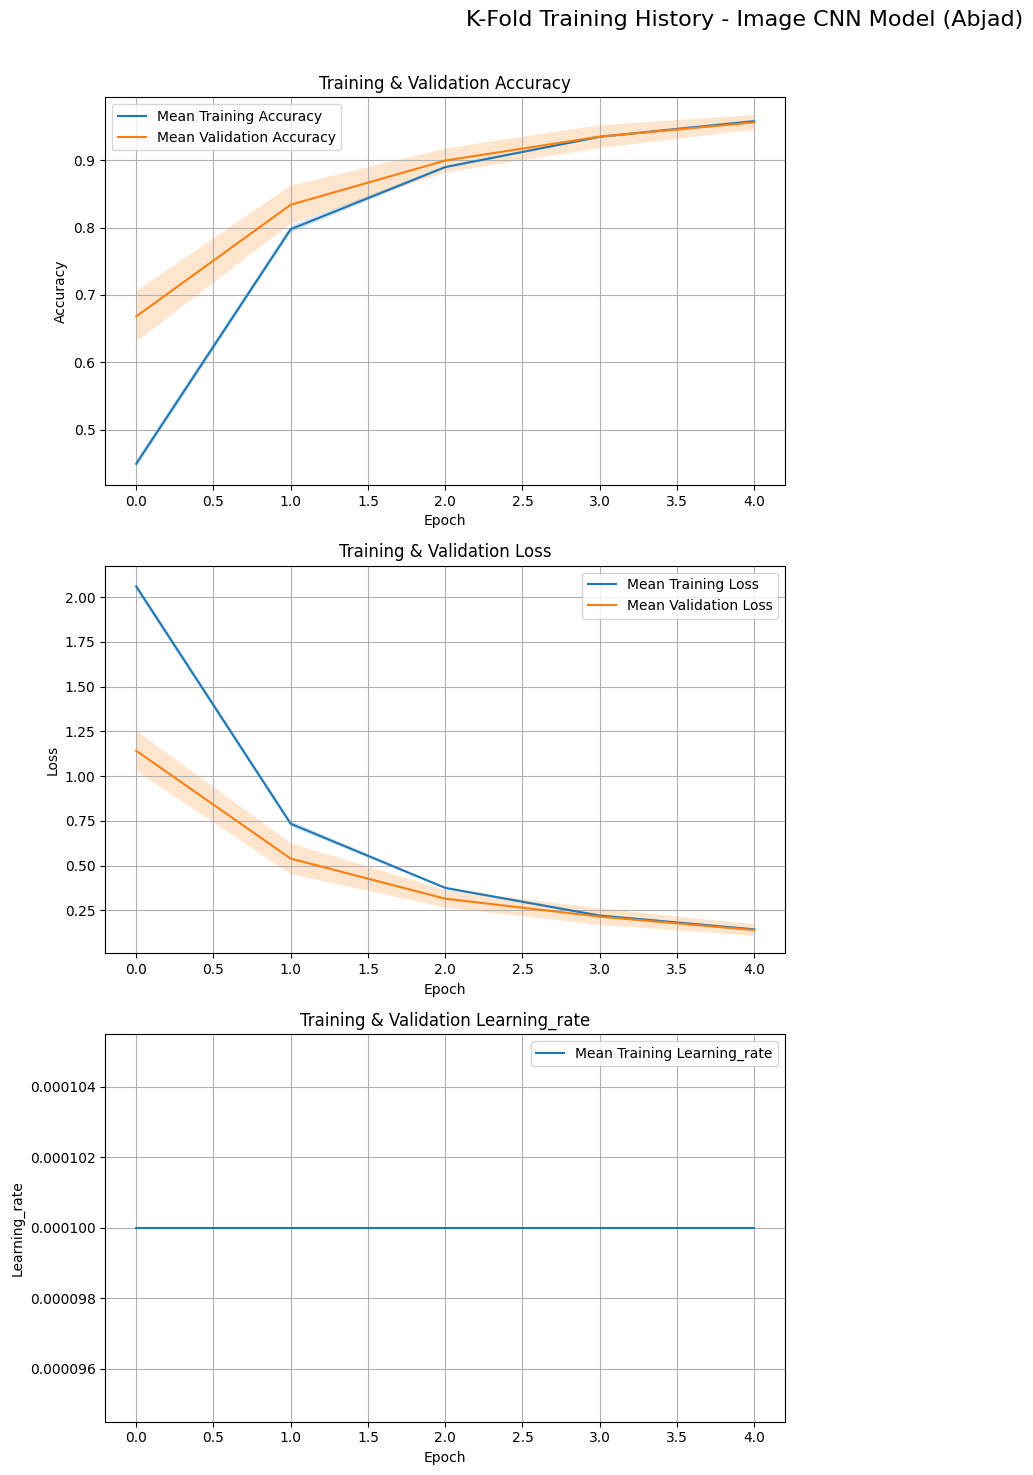


 Hasil K-Fold Training Model Transformer Video (Kata):


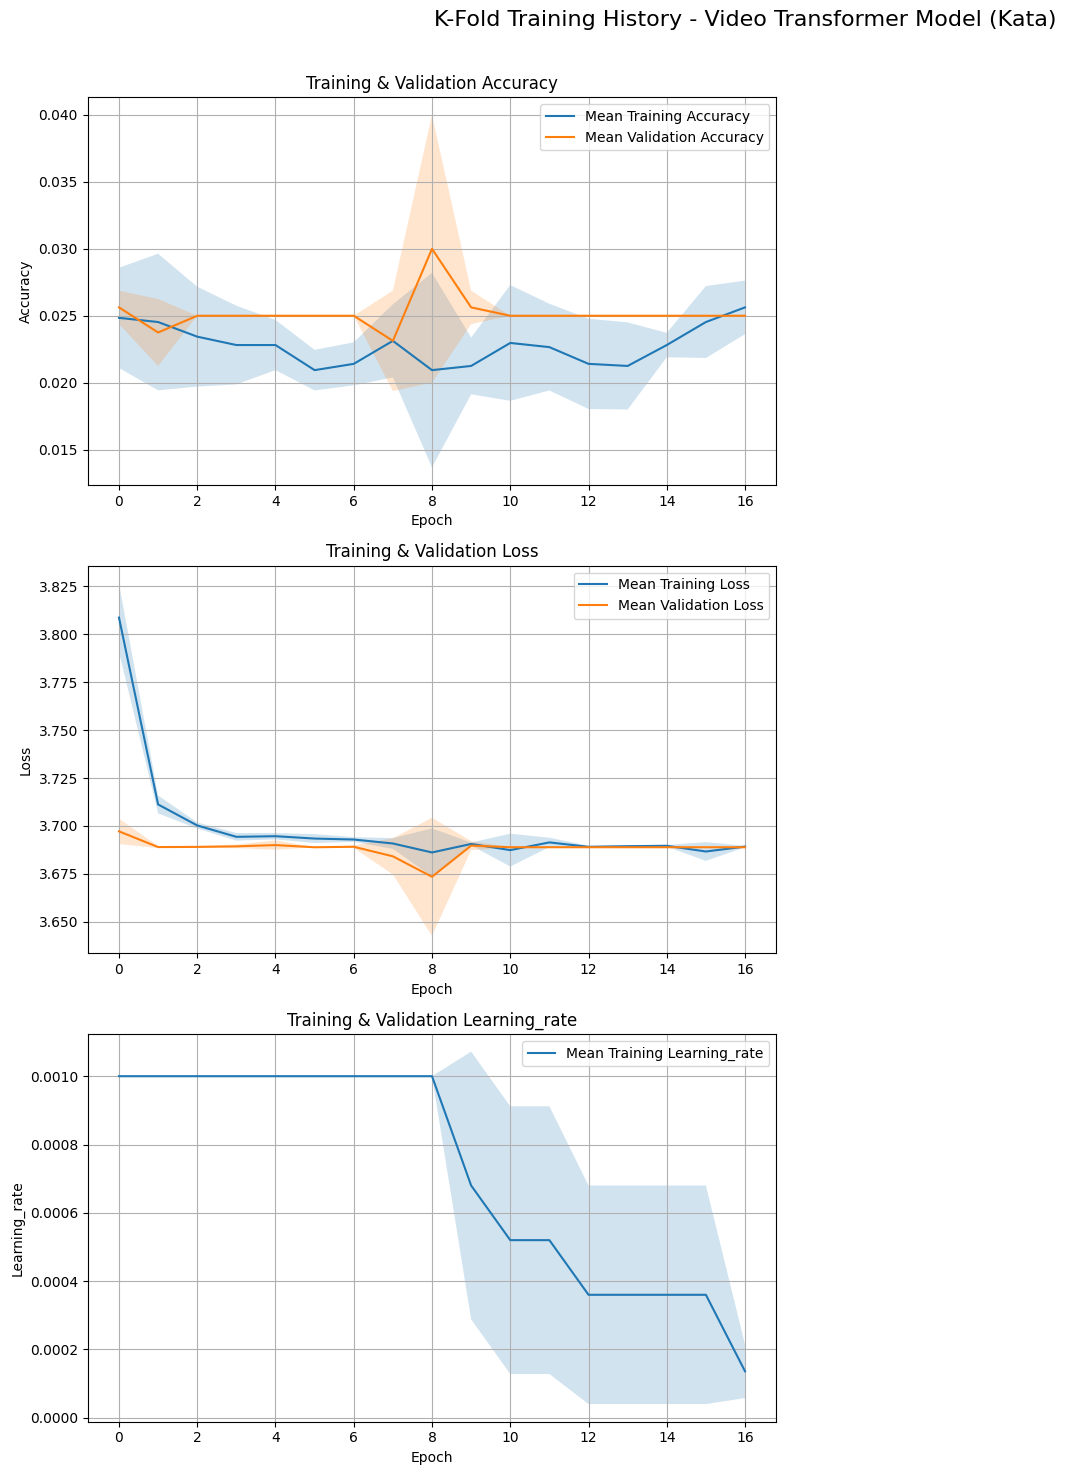

Model best_bisindo_image_model.h5 berhasil dimuat.

Evaluasi detail untuk Final Image CNN Model (Abjad) (Model: best_bisindo_image_model.h5):
Found 1589 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step
Test Loss: 0.1102
Test Accuracy: 0.9679

Final Image CNN Model (Abjad) - Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        45
           B       1.00      0.80      0.89        59
           C       1.00      0.97      0.99        68
           D       0.91      0.99      0.94        68
           E       1.00      1.00      1.00        63
           F       0.83      1.00      0.90        57
           G       1.00      1.00      1.00        70
           H       1.00      0.95      0.97        55
           I       1.00      0.94      0.97        69
           J       0.98      1.00      0.99        62
           K       1.00      0.93      0.96        57
           L       0.89      1.00      0.94        62
           M       0.92      0.93      0.92        71
           N       0.94      0.90      0.92        70
           O       1.00      1.00      1.00        

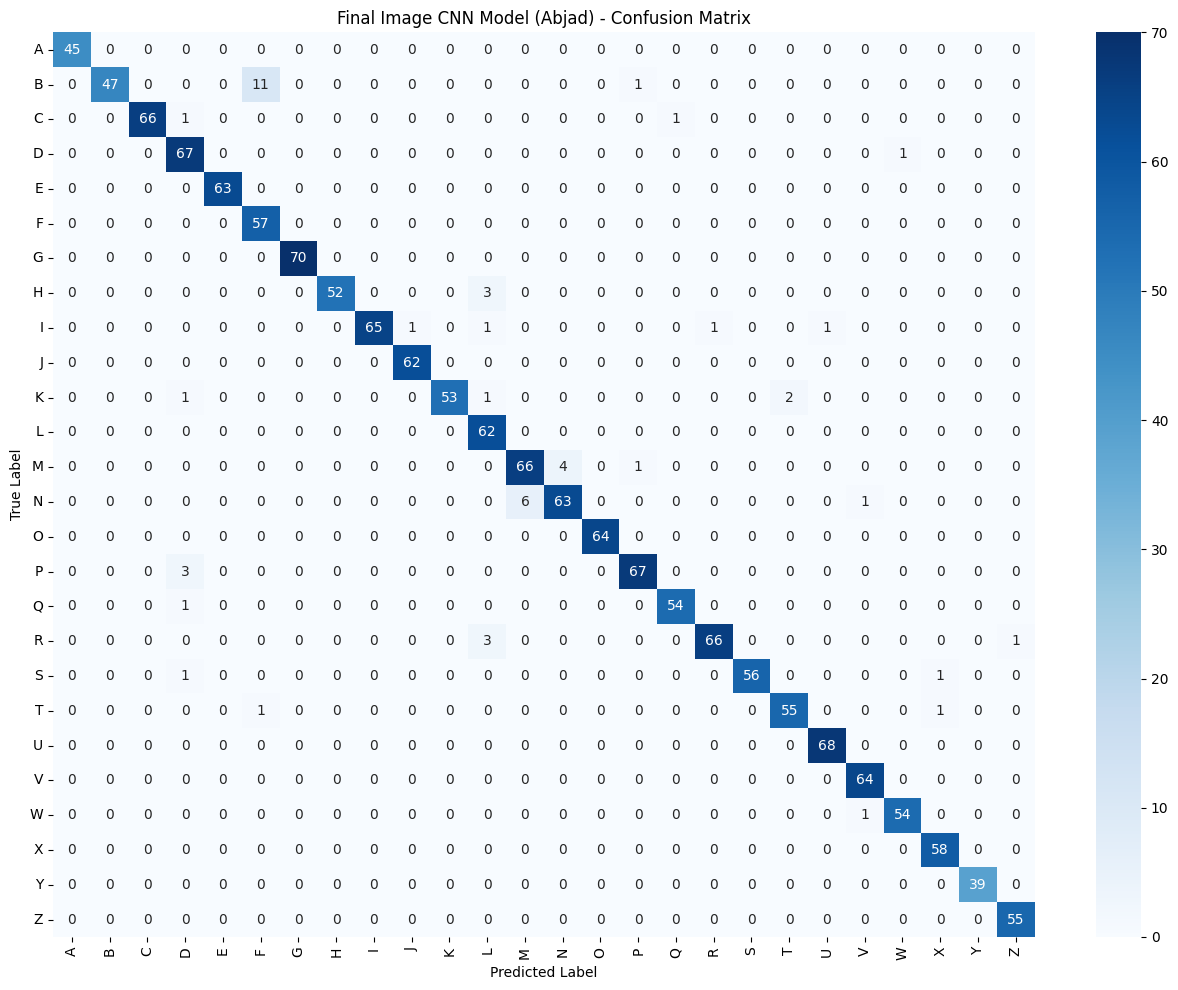

Model best_bisindo_landmark_model.h5 berhasil dimuat.

Evaluasi detail untuk Final Landmark MLP Model (Abjad) (Model: best_bisindo_landmark_model.h5):
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test Loss: 0.3119
Test Accuracy: 0.9119

Final Landmark MLP Model (Abjad) - Classification Report:
              precision    recall  f1-score   support

           A       0.76      0.87      0.81        45
           B       0.90      0.75      0.81        59
           C       0.97      0.87      0.91        68
           D       0.79      0.96      0.87        68
           E       0.93      1.00      0.96        63
           F       0.91      0.89      0.90        57
           G       0.93      0.99      0.96        70
           H       0.88      0.80      0.84        55
           I       1.00      1.00      1.00        69
           J       1.00      0.97      0.98        62
           K       0.82      0.89      0.86        57
           L       0.92      0.95      0.94        62
        

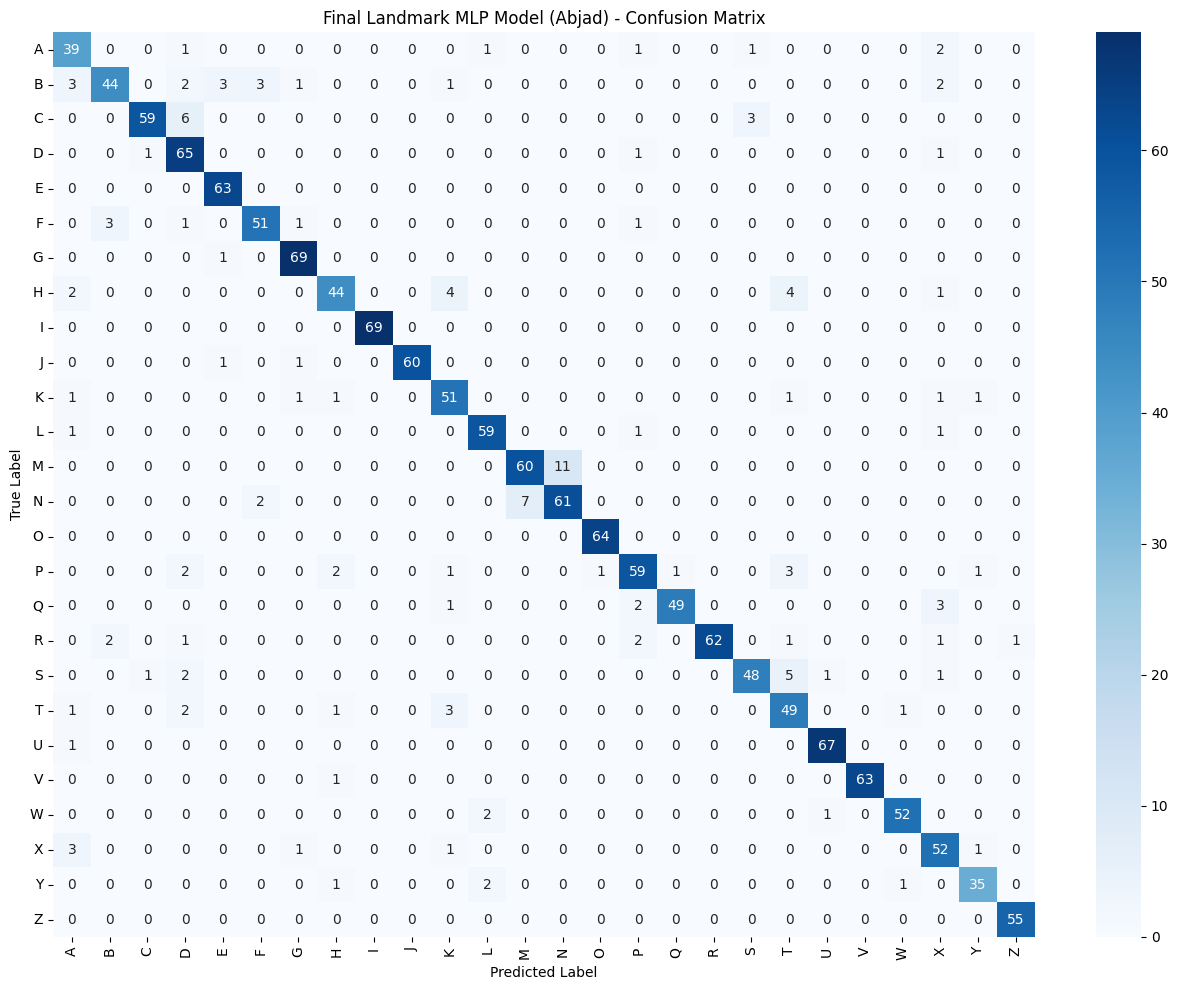

Model best_bisindo_video_lstm_model.h5 berhasil dimuat.

Evaluasi detail untuk Final Video LSTM Model (Kata) (Model: best_bisindo_video_lstm_model.h5):
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


Test Loss: 0.3481
Test Accuracy: 0.9450

Final Video LSTM Model (Kata) - Classification Report:
               precision    recall  f1-score   support

          Apa       0.82      0.90      0.86        10
    Apa Kabar       1.00      1.00      1.00        10
    Bagaimana       0.77      1.00      0.87        10
         Baik       1.00      0.90      0.95        10
      Belajar       0.91      1.00      0.95        10
       Berapa       1.00      0.90      0.95        10
      Berdiri       0.83      1.00      0.91        10
      Bingung       1.00      1.00      1.00        10
          Dia       0.90      0.90      0.90        10
       Dimana       0.82      0.90      0.86        10
        Duduk       0.89      0.80      0.84        10
         Halo       1.00      1.00      1.00        10
       Kalian       0.91      1.00      0.95        10
         Kami       1.00      1.00      1.00        10
         Kamu       1.00      1.00      1.00        10
        Kapan       1.0

In [8]:
def plot_kfold_training_history(histories_list, title="K-Fold Training History"):
    if not histories_list:
        print(f"Tidak ada history untuk diplot: {title}")
        return

    sample_history = histories_list[0].history
    metrics = [key for key in sample_history.keys() if not key.startswith('val_')]
    val_metrics = [key for key in sample_history.keys() if key.startswith('val_')]

    plt.figure(figsize=(15, 5 * len(metrics)))

    for i, metric_name in enumerate(metrics):
        val_metric_name = 'val_' + metric_name

        all_folds_metric = []
        all_folds_val_metric = []
        min_epochs = min(len(h.history[metric_name]) for h in histories_list)

        for h in histories_list:
            all_folds_metric.append(h.history[metric_name][:min_epochs])
            if val_metric_name in h.history:
                all_folds_val_metric.append(h.history[val_metric_name][:min_epochs])

        mean_metric = np.mean(all_folds_metric, axis=0)
        std_metric = np.std(all_folds_metric, axis=0)

        plt.subplot(len(metrics), 2, 2*i + 1)
        plt.plot(mean_metric, label=f'Mean Training {metric_name.capitalize()}')
        plt.fill_between(range(min_epochs), mean_metric - std_metric, mean_metric + std_metric, alpha=0.2)

        if all_folds_val_metric:
            mean_val_metric = np.mean(all_folds_val_metric, axis=0)
            std_val_metric = np.std(all_folds_val_metric, axis=0)
            plt.plot(mean_val_metric, label=f'Mean Validation {metric_name.capitalize()}')
            plt.fill_between(range(min_epochs), mean_val_metric - std_val_metric, mean_val_metric + std_val_metric, alpha=0.2)

        plt.title(f'Training & Validation {metric_name.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name.capitalize())
        plt.legend()
        plt.grid(True)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def display_final_model_evaluation(model_path, X_test_data, y_test_data_onehot, class_names_list, title="Final Model Evaluation", is_image_cnn=False, df_test_cnn=None, custom_objects_to_load=None):
    if not os.path.exists(model_path):
        print(f"Model tidak ditemukan di {model_path}. Skipping evaluasi untuk {title}.")
        return

    try:
        model = keras.models.load_model(model_path, custom_objects=custom_objects_to_load)
        print(f"Model {os.path.basename(model_path)} berhasil dimuat.")
    except Exception as e:
        print(f"Error memuat model {model_path}: {e}")
        return


    print(f"\nEvaluasi detail untuk {title} (Model: {os.path.basename(model_path)}):")

    if is_image_cnn:
        if df_test_cnn is None or len(df_test_cnn) == 0:
            print("DataFrame test untuk Image CNN tidak tersedia.")
            return
        test_generator_final = val_image_datagen.flow_from_dataframe(
            dataframe=df_test_cnn,
            x_col='filepath',
            y_col='label_str',
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=32,
            class_mode='categorical',
            shuffle=False
        )
        loss, accuracy = model.evaluate(test_generator_final, verbose=0)
        y_pred_probs = model.predict(test_generator_final)
        y_true_classes = test_generator_final.classes
    else:
        if X_test_data is None or X_test_data.shape[0] == 0:
            print(f"Data test untuk {title} tidak tersedia.")
            return
        loss, accuracy = model.evaluate(X_test_data, y_test_data_onehot, verbose=0)
        y_pred_probs = model.predict(X_test_data)
        y_true_classes = np.argmax(y_test_data_onehot, axis=1)

    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    print(f"\n{title} - Classification Report:")
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names_list, labels=np.arange(len(class_names_list)), zero_division=0)
    print(report)

    if len(class_names_list) < 30:
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(len(class_names_list)))
        df_cm = pd.DataFrame(conf_mat, index=class_names_list, columns=class_names_list)
        plt.figure(figsize=(max(10, len(class_names_list)//2), max(8, len(class_names_list)//2.5)))
        try:
            import seaborn as sns
            sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
        except ImportError:
            plt.imshow(conf_mat, interpolation='nearest', cmap='Blues'); plt.colorbar()
        plt.title(f'{title} - Confusion Matrix')
        plt.ylabel('True Label'); plt.xlabel('Predicted Label')
        plt.xticks(rotation=90); plt.yticks(rotation=0)
        plt.tight_layout(); plt.show()

if all_cnn_histories:
    print("Hasil K-Fold Training Model CNN Gambar (Abjad):")
    plot_kfold_training_history(all_cnn_histories, "K-Fold Training History - Image CNN Model (Abjad)")
if all_transformer_histories:
    print("\n Hasil K-Fold Training Model Transformer Video (Kata):")
    plot_kfold_training_history(all_transformer_histories, "K-Fold Training History - Video Transformer Model (Kata)")

if os.path.exists(BEST_IMAGE_MODEL_FILE) and len(df_images_test) > 0:
    display_final_model_evaluation(BEST_IMAGE_MODEL_FILE, None, None, image_classes,
                                   "Final Image CNN Model (Abjad)", is_image_cnn=True, df_test_cnn=df_images_test)
if os.path.exists(BEST_LANDMARK_MODEL_FILE) and X_lm_img_test.shape[0] > 0:
    display_final_model_evaluation(BEST_LANDMARK_MODEL_FILE, X_lm_img_test, y_img_test_onehot, image_classes,
                                   "Final Landmark MLP Model (Abjad)")
if os.path.exists(BEST_VIDEO_LSTM_MODEL_FILE) and X_vid_seq_test.shape[0] > 0:
    display_final_model_evaluation(BEST_VIDEO_LSTM_MODEL_FILE, X_vid_seq_test, y_vid_test_onehot, video_classes,
                                   "Final Video LSTM Model (Kata)")

if os.path.exists(BEST_VIDEO_TRANSFORMER_MODEL_FILE) and X_vid_seq_test.shape[0] > 0:
     display_final_model_evaluation(BEST_VIDEO_TRANSFORMER_MODEL_FILE, X_vid_seq_test, y_vid_test_onehot, video_classes,
                                    "Final Video Transformer Model (Kata)",
                                    custom_objects_to_load=transformer_custom_objects_for_training)

# Sel 10: Fungsi Inferensi untuk Aplikasi (Modifikasi untuk memuat model terbaik & Transformer)

In [9]:
loaded_landmark_model = None
loaded_image_class_mapping = {}
loaded_video_model_lstm_h5 = None
loaded_video_model_transformer_h5 = None
loaded_video_class_mapping = {}

transformer_custom_objects_load = {'PositionalEncoding': PositionalEncoding}

try:
    if os.path.exists(BEST_LANDMARK_MODEL_FILE):
        loaded_landmark_model = keras.models.load_model(BEST_LANDMARK_MODEL_FILE)
        print(f"Model Landmark (abjad) '{os.path.basename(BEST_LANDMARK_MODEL_FILE)}' berhasil dimuat.")
    with open(IMAGE_CLASS_MAPPING_FILE, 'r') as f:
        loaded_image_class_mapping = {int(k): v for k,v in json.load(f).items()}
except Exception as e:
    print(f"Error memuat model landmark atau mapping gambar: {e}")

try:
    if os.path.exists(BEST_VIDEO_LSTM_MODEL_FILE):
        loaded_video_model_lstm_h5 = keras.models.load_model(BEST_VIDEO_LSTM_MODEL_FILE)
        print(f"Model Video LSTM (kata) '{os.path.basename(BEST_VIDEO_LSTM_MODEL_FILE)}' berhasil dimuat.")
    else:
        print("Model Video LSTM H5 tidak ditemukan.")

    if os.path.exists(BEST_VIDEO_TRANSFORMER_MODEL_FILE):
        loaded_video_model_transformer_h5 = keras.models.load_model(
            BEST_VIDEO_TRANSFORMER_MODEL_FILE,
            custom_objects=transformer_custom_objects_load
        )
        print(f"Model Video Transformer (kata) '{os.path.basename(BEST_VIDEO_TRANSFORMER_MODEL_FILE)}' berhasil dimuat.")
    else:
        print("Model Video Transformer H5 tidak ditemukan.")

    with open(VIDEO_CLASS_MAPPING_FILE, 'r') as f:
        loaded_video_class_mapping = {int(k): v for k,v in json.load(f).items()}
except Exception as e:
    print(f"Error memuat model video atau mapping video: {e}")


def predict_static_sign_from_image_obj(image_bgr_input, hands_detector):
    if loaded_landmark_model is None or not loaded_image_class_mapping:
        return "Model abjad tidak termuat", 0.0, image_bgr_input

    landmarks_list, processed_image = extract_hand_landmarks(image_bgr_input, hands_detector)
    if not landmarks_list:
        return "Tidak ada tangan terdeteksi", 0.0, processed_image

    X_input = np.array([landmarks_list[0]], dtype=np.float32)
    prediction = loaded_landmark_model.predict(X_input, verbose=0)
    pred_idx = np.argmax(prediction[0])
    confidence = float(prediction[0][pred_idx])
    pred_class = loaded_image_class_mapping.get(pred_idx, "Unknown")
    return pred_class, confidence, processed_image

def predict_dynamic_sign_from_landmarks_sequence(landmark_sequence_input, model_choice="transformer"):
    h5_model_to_use = loaded_video_model_lstm_h5 if model_choice == "lstm" else loaded_video_model_transformer_h5

    if not loaded_video_class_mapping or h5_model_to_use is None:
        return f"Model kata ({model_choice}) H5 tidak termuat", 0.0

    X_input = np.array([landmark_sequence_input], dtype=np.float32)
    prediction = h5_model_to_use.predict(X_input, verbose=0)
    pred_idx = np.argmax(prediction[0])
    confidence = float(prediction[0][pred_idx])
    pred_class = loaded_video_class_mapping.get(pred_idx, "Unknown")
    return pred_class, confidence

def process_video_file_for_prediction(video_path, hands_detector, model_choice_vid="transformer", num_target_frames=NUM_FRAMES_VIDEO, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    if not video_path: return None, "Tidak ada video"
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened(): return None, "Error membuka video"
    total_frames_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames_video - 1, num_target_frames, dtype=int) if total_frames_video > num_target_frames else range(total_frames_video)
    video_landmarks_sequence = []
    first_processed_frame_with_landmark = None
    for i in range(total_frames_video):
        ret, frame = cap.read()
        if not ret: break
        if i in frame_indices:
            resized_frame = cv2.resize(frame, target_size)
            landmarks_list, processed_display_frame = extract_hand_landmarks(resized_frame, hands_detector)
            if first_processed_frame_with_landmark is None and landmarks_list:
                 first_processed_frame_with_landmark = cv2.cvtColor(processed_display_frame, cv2.COLOR_BGR2RGB)
            video_landmarks_sequence.append(landmarks_list[0] if landmarks_list else np.zeros(NUM_LANDMARK_FEATURES))
    cap.release()
    while len(video_landmarks_sequence) < num_target_frames: video_landmarks_sequence.append(np.zeros(NUM_LANDMARK_FEATURES))
    video_landmarks_sequence = video_landmarks_sequence[:num_target_frames]
    if not any(lm.any() for lm in video_landmarks_sequence):
        return first_processed_frame_with_landmark if first_processed_frame_with_landmark is not None else np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8), "Tidak ada landmark terdeteksi di video"
    pred_class, confidence = predict_dynamic_sign_from_landmarks_sequence(np.array(video_landmarks_sequence), model_choice=model_choice_vid)
    return first_processed_frame_with_landmark, f"Kata ({model_choice_vid}): {pred_class} (Conf: {confidence:.2f})"

print("Fungsi inferensi (H5-only) siap.")

Model Landmark (abjad) 'best_bisindo_landmark_model.h5' berhasil dimuat.


Model Video LSTM (kata) 'best_bisindo_video_lstm_model.h5' berhasil dimuat.


Model Video Transformer (kata) 'best_bisindo_video_transformer_model.h5' berhasil dimuat.
Fungsi inferensi (H5-only) siap.


# Sel 11: Pengujian Akhir

--- Menguji Model Prediksi Gambar Statis (Abjad) ---
Hasil Prediksi Gambar: Kelas = E, Confidence = 0.8910


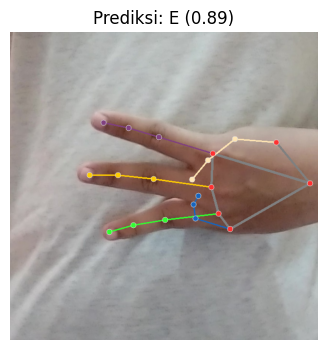


--- Menguji Model Prediksi Video Dinamis (Kata) ---
Hasil Prediksi Video: Kata (transformer): Kapan (Conf: 0.03)


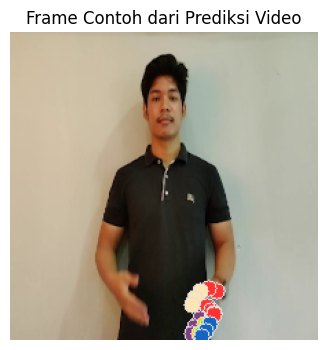


--- Menguji Fungsi Teks ke Isyarat ---
Input Teks: "Saya B"
Deskripsi Hasil: 
Kata 'saya': 'S' 'A' 'Y' 'A'
Kata 'b': 'B'
Menampilkan 5 gambar isyarat:


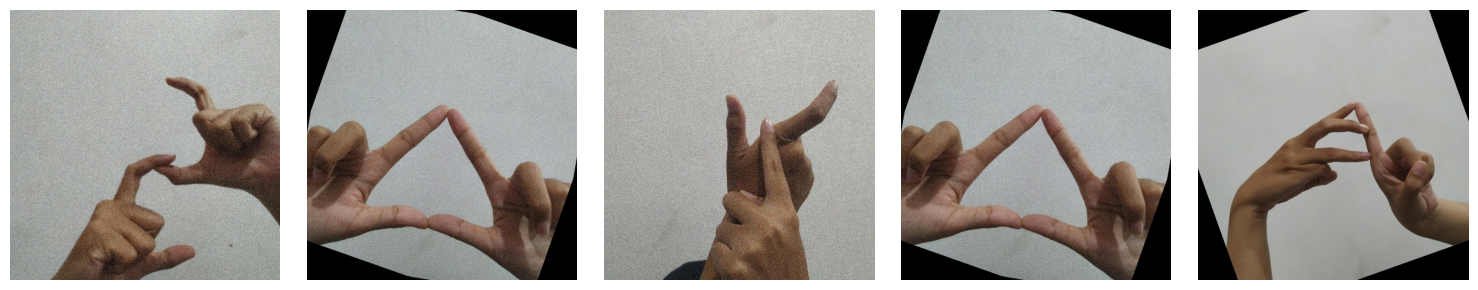


Pengujian selesai.


In [14]:
IMAGE_SIGN_FOLDER = IMAGE_TRAIN_PATH

def get_sign_image_path(letter):
    """Mencari path gambar untuk sebuah huruf."""
    letter_upper = letter.upper()
    letter_dir_path = os.path.join(IMAGE_SIGN_FOLDER, letter_upper)
    if os.path.exists(letter_dir_path) and os.path.isdir(letter_dir_path):
        try:
            image_files = [f for f in os.listdir(letter_dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if image_files:
                return os.path.join(letter_dir_path, image_files[0])
        except Exception as e:
            print(f"Error akses gambar {letter_upper}: {e}")
    return None

def text_to_sign_display(text_input):
    """Mengonversi teks input menjadi deskripsi dan daftar path gambar isyarat."""
    if not text_input:
        return "Teks input kosong.", []

    output_image_paths = []
    output_description_parts = []
    words = text_input.strip().lower().split()

    for word in words:
        description = f"Kata '{word}': "
        letters_found = []
        for letter in word:
            if 'a' <= letter <= 'z':
                img_path = get_sign_image_path(letter)
                if img_path:
                    output_image_paths.append(img_path)
                    letters_found.append(f"'{letter.upper()}'")

        if letters_found:
            description += " ".join(letters_found)
        else:
            description += "(Tidak ada gambar ditemukan)"
        output_description_parts.append(description)

    final_description = "\n".join(output_description_parts)
    return final_description, output_image_paths

def process_video_file_for_prediction(video_path, hands_detector, model_choice_vid="transformer", num_target_frames=NUM_FRAMES_VIDEO, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    if not video_path: return None, "Tidak ada video"

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened(): return None, "Error membuka video"

    total_frames_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames_video - 1, num_target_frames, dtype=int) if total_frames_video > num_target_frames else range(total_frames_video)

    video_landmarks_sequence = []
    first_processed_frame_with_landmark = None

    for i in range(total_frames_video):
        ret, frame = cap.read()
        if not ret: break
        if i in frame_indices:
            resized_frame = cv2.resize(frame, target_size)
            landmarks_list, processed_display_frame = extract_hand_landmarks(resized_frame, hands_detector)
            if first_processed_frame_with_landmark is None and landmarks_list:
                first_processed_frame_with_landmark = cv2.cvtColor(processed_display_frame, cv2.COLOR_BGR2RGB)
            video_landmarks_sequence.append(landmarks_list[0] if landmarks_list else np.zeros(NUM_LANDMARK_FEATURES))

    cap.release()

    while len(video_landmarks_sequence) < num_target_frames:
        video_landmarks_sequence.append(np.zeros(NUM_LANDMARK_FEATURES))
    video_landmarks_sequence = video_landmarks_sequence[:num_target_frames]

    sequence_array = np.array(video_landmarks_sequence)

    if not sequence_array.any():
        if first_processed_frame_with_landmark is None:
            first_processed_frame_with_landmark = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
        return first_processed_frame_with_landmark, "Tidak ada landmark terdeteksi di video"

    pred_class, confidence = predict_dynamic_sign_from_landmarks_sequence(sequence_array, model_choice=model_choice_vid)

    return first_processed_frame_with_landmark, f"Kata ({model_choice_vid}): {pred_class} (Conf: {confidence:.2f})"

mp_hands_test = mp.solutions.hands
hands_test_detector = mp_hands_test.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
hands_video_test_detector = mp_hands_test.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

print("--- Menguji Model Prediksi Gambar Statis (Abjad) ---")
if 'loaded_landmark_model' in globals() and loaded_landmark_model and image_classes:
    try:
        sample_letter = image_classes[4]
        sample_letter_path_dir = os.path.join(IMAGE_TRAIN_PATH, sample_letter)
        if os.path.exists(sample_letter_path_dir) and os.listdir(sample_letter_path_dir):
            sample_image_name = [f for f in os.listdir(sample_letter_path_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][0]
            sample_image_path = os.path.join(sample_letter_path_dir, sample_image_name)
            test_image_bgr = cv2.imread(sample_image_path)
            if test_image_bgr is not None:
                pred_class, confidence, processed_img = predict_static_sign_from_image_obj(test_image_bgr, hands_test_detector)
                print(f"Hasil Prediksi Gambar: Kelas = {pred_class}, Confidence = {confidence:.4f}")
                plt.figure(figsize=(4, 4)); plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
                plt.title(f"Prediksi: {pred_class} ({confidence:.2f})"); plt.axis('off'); plt.show()
    except Exception as e:
        print(f"Error saat menguji prediksi gambar statis: {e}")
else:
    print("Model landmark tidak termuat. Tes gambar statis dilewati.")

print("\n--- Menguji Model Prediksi Video Dinamis (Kata) ---")
if 'loaded_video_model_transformer_h5' in globals() and loaded_video_model_transformer_h5:
    try:
        sample_word = video_classes[3]
        sample_word_path_dir = os.path.join(VIDEO_RAW_PATH, sample_word)
        if os.path.exists(sample_word_path_dir) and os.listdir(sample_word_path_dir):
            sample_video_name = [f for f in os.listdir(sample_word_path_dir) if f.lower().endswith(('.mp4', '.avi', '.mov'))][0]
            sample_video_path = os.path.join(sample_word_path_dir, sample_video_name)

            display_frame, prediction_text = process_video_file_for_prediction(sample_video_path, hands_video_test_detector, model_choice_vid="transformer")
            print(f"Hasil Prediksi Video: {prediction_text}")
            if display_frame is not None:
                plt.figure(figsize=(4, 4)); plt.imshow(display_frame)
                plt.title(f"Frame Contoh dari Prediksi Video"); plt.axis('off'); plt.show()
    except Exception as e:
        print(f"Error saat menguji prediksi video dinamis: {e}")
else:
    print("Model video tidak termuat. Tes video dinamis dilewati.")

print("\n--- Menguji Fungsi Teks ke Isyarat ---")
if 'loaded_image_class_mapping' in globals() and loaded_image_class_mapping:
    test_text = "Saya B"
    print(f"Input Teks: \"{test_text}\"")

    description, images_paths = text_to_sign_display(test_text)

    print(f"Deskripsi Hasil: \n{description}")
    if images_paths:
        print(f"Menampilkan {len(images_paths)} gambar isyarat:")
        plt.figure(figsize=(len(images_paths) * 3, 3))
        for i, img_path in enumerate(images_paths):
            if img_path and os.path.exists(img_path):
                img = cv2.imread(img_path)
                plt.subplot(1, len(images_paths), i + 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.axis('off')
        plt.tight_layout(); plt.show()
else:
    print("Mapping kelas gambar tidak termuat. Tes teks ke isyarat dilewati.")

hands_test_detector.close()
hands_video_test_detector.close()
print("\nPengujian selesai.")